
# ManifestoBERTa for ideological polarization

This notebook documents the full analytical process developed to measure and evaluate ideological polarization in Portugal using electoral programs and transformer-based text models. The workflow integrates data from the Manifesto Project, applies modern natural-language processing techniques, and produces harmonized ideological indicators,most notably RILE and GAL-TAN,for both historical and recent election years.

The process is composed of several stages. It begins with systematic preprocessing and cleaning of the electoral program corpus, followed by the generation of topic distributions using ManifestoBERTa for the 2024 elections. These model-based topic predictions are then used to compute preliminary RILE and GAL-TAN scores. To ensure comparability with established Manifesto Project metrics, a calibration step aligns the modelled scores with the official historical scores through post-hoc linear normalization. After calibration, the notebook constructs time-series datasets, visualizations, and summary statistics to evaluate trends in ideological positioning and polarization across parties and election cycles.

Together, these steps form a coherent methodological pipeline that allows for the analysis of ideological dynamics over time, the integration of machine-generated scores into historical series, and the assessment of polarization patterns within the broader context of Portuguese political developments.

# <b><font color='#D3D3D3'><font size="6">Table of Content</font></font></b><a class="anchor" id="Table of Content"></a>

* [Model setup](#Model-setup)
* [Data Preparation](#Data-Preparation)
* [Predicting Topics from Quasi-Sentences](#Predicting-Topics-From-Quasi-Sentences)
* [Manual Check of Confidence Scores](#Manual-Check-of-Confidence-Scores)
* [Visualizing Modelled RILE and GAL-TAN Scores](#Visualizing-Modelled-RILE-and-GAL-TAN-Scores)

* [Comparison With Official Scores](#Comparison-With-Official-Scores)
    * [Building a Portuguese Dataset](#Building-a-Portuguese-Dataset)
    * [Visualization of Official Scores](#Visualization-of-Official-Scores)

* [Combined Dataframe](#Combined-Dataframe)

* [Calibration of Model Scores](#Calibration-of-Model-Scores)
    * [Visualizations of Calibrated Scores](#Visualizations-of-Calibrated-Scores)
    * [Evaluation of Calibration](#Evaluation-of-Calibration)

* [Visualizations](#Visualizations)
    * [RILE](#RILE)
    * [GAL–TAN](#GAL-TAN)
    * [Political Compass](#Political-Compass)
    * [Overall Polarization Over Time](#Overall-Polarization-Over-Time)

* [Analysis](#analysis)
    * [RILE Change in Topics](#RILE-Change-in-Topics)
    * [RILE Top Topics](#RILE-Top-Topics)
    * [GAL–TAN Change in Topics](#GAL-TAN-Change-in-Topics)
    * [GAL–TAN Top Topics](#GAL-TAN-Top-Topics)

* [Missing Official Data](#Missing-Official-Data)

## Model setup

In [ ]:
# ==== SYSTEM & PYTHON SETUP ====
!apt-get -qq update
!apt-get -qq install -y tesseract-ocr tesseract-ocr-por poppler-utils > /dev/null

# core python deps
!pip -q install pymupdf pdfminer.six pdf2image pytesseract pillow
!pip -q install spacy==3.7.5 pt_core_news_lg==3.7.0
!pip -q install transformers==4.44.2 torch accelerate
!pip -q install pandas numpy scikit-learn tqdm matplotlib

import torch, sys, os, platform, shutil
print("Python:", sys.version)
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

import spacy, pkgutil
print("spaCy:", spacy.__version__)
!python -m spacy download pt_core_news_lg -q
print("Tesseract path:", shutil.which("tesseract"))
print("poppler (pdftoppm) path:", shutil.which("pdftoppm"))


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 56.0 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pt_core_news_lg==3.7.0 (from versions: none)
ERROR: No matching distribution found for pt_core_news_lg==3.7.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 80.1 MB/s eta 0:00:00
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Torch: 2.9.0+cu126 | CUDA available: True
CUDA device: Tesla T4
spaCy: 3.8.11
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 851.4 kB/s eta 0:00:00
✔ Download and installation su

In [ ]:
# ==== CONFIG ====
from pathlib import Path
CONTENT_DIR = Path("/content")          # where your PDFs and official dataset live
PDF_GLOB    = "*.pdf"                  # we’ll filter names like PARTY_YEAR.pdf
MODEL_ID    = "manifesto-project/manifestoberta-xlm-roberta-56policy-topics-context-2024-1-1"

# ==== HUMAN REVIEW CONFIG ====
CONF_THRESH = 0.75          # flag anything below this
MAX_REVIEW  = None          # or an int (e.g., 500) to cap rows per doc
TOPK        = 3             # how many top labels to show for reviewers

# ==== FOLDERS ====
BASE = Path("/content/_mp_pipeline")
EXTRACTED = BASE/"extracted"        # raw text from PDFs (OCR fallback)
QSENTS    = BASE/"quasisentences"   # jsonl with quasi-sentences
PRED      = BASE/"predictions"      # per-qs predictions
REPORTS   = BASE/"reports"          # CSV summaries
for p in [BASE, EXTRACTED, QSENTS, PRED, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

print("Working dirs:")
for p in [EXTRACTED, QSENTS, PRED, REPORTS]:
    print(" -", p)

# ==== UTILS ====
import re, json, numpy as np, pandas as pd
from pdf2image import convert_from_path
import pytesseract, fitz
from tqdm import tqdm

def parse_doc_id(pdf_path):
    # expects /content/PARTY_YEAR.pdf -> party=str, year=int
    stem = Path(pdf_path).stem
    m = re.match(r"(?P<party>[A-Za-z\-]+)_(?P<year>\d{4})$", stem)
    if not m:
        raise ValueError(f"Filename must be PARTY_YEAR.pdf, got: {pdf_path}")
    return m.group("party").upper(), int(m.group("year")), stem

def list_input_pdfs():
    pdfs = sorted([p for p in CONTENT_DIR.glob(PDF_GLOB) if re.match(r".*_20(19|22|24|25)\.pdf$", p.name)])
    print(f"Found {len(pdfs)} PDFs in /content for 2022/2024:")
    for p in pdfs:
        print(" •", p.name)
    return pdfs


Working dirs:
 - /content/_mp_pipeline/extracted
 - /content/_mp_pipeline/quasisentences
 - /content/_mp_pipeline/predictions
 - /content/_mp_pipeline/reports


## Data Preparation

**Step 1 – PDF extraction and text cleaning**

In the first step, all electoral program PDFs are converted into plain text. Whenever possible, the script uses the PDF’s native text layer; for scanned documents it falls back to OCR. The extracted text is then cleaned by removing headers, footers, page numbers, boilerplate labels (tables, figures, etc.), control characters and spurious line breaks, so that the output is a continuous, readable version of each electoral program saved as a `.txt` file plus a small metadata JSON.

**Step 2 – Quasi-sentence unitisation**

In the second step, the cleaned texts are segmented into “quasi-sentences”, i.e. the smallest meaningful units used for Manifesto Project-style coding. The script uses a Portuguese spaCy model for sentence detection and then applies custom splitting rules on punctuation and connectors to further break up long sentences. Very short, noisy or header-like fragments are filtered out, and the remaining fragments are merged or capped to keep a consistent unit size. The final quasi-sentences are written to one JSONL file per electoral program, ready for topic classification and RILE/GAL–TAN computation.


In [ ]:
# =========================
# STEP 01 - BETTER EXTRACTION TO CLEAN TEXT
# =========================
from pathlib import Path
import re, json, math
import fitz
import numpy as np
import pandas as pd
from pdf2image import convert_from_path
import pytesseract

# ---- Paths (reuse existing globals if present)
BASE = Path(globals().get("BASE", "/content/_mp_pipeline"))
CONTENT_DIR = Path(globals().get("CONTENT_DIR", "/content"))
EXTRACTED = BASE / "extracted"
QSENTS    = BASE / "quasisentences"
for p in [BASE, EXTRACTED, QSENTS]:
    p.mkdir(parents=True, exist_ok=True)

PDF_GLOB = globals().get("PDF_GLOB", "*.pdf")

# ========= UTILITIES =========

def parse_doc_id(pdf_path):
    stem = Path(pdf_path).stem
    m = re.match(r"(?P<party>[A-Za-z\-]+)_(?P<year>\d{4})$", stem)
    if not m:
        raise ValueError(f"Filename must be PARTY_YEAR.pdf, got: {pdf_path}")
    return m.group("party").upper(), int(m.group("year")), stem

def list_input_pdfs():
    pdfs = sorted([
        p for p in CONTENT_DIR.glob(PDF_GLOB)
        if re.match(r".*_20(19|22|24|25)\.pdf$", p.name)
    ])
    print(f"Found {len(pdfs)} PDFs:")
    for p in pdfs:
        print(" •", p.name)
    return pdfs

# --------- CLEANING HELPERS ---------

_ILLEGAL_CTRL = re.compile(r"[\x00-\x08\x0B-\x0C\x0E-\x1F]")

HEADER_FOOTER_HINTS = re.compile(
    r"^(?:p[aá]gina\s*\d+|\d+\s*/\s*\d+|sum[áa]rio|índice|conte[úu]do|www\.|https?://|copyright|todos os direitos|confidencial)$",
    re.I
)
BOILERPLATE_LINE = re.compile(
    r"^(?:tabela|gr[áa]fico|figura|quadro|anexo|fonte:?|nota:?|cap[íi]tulo|sec(ção|ao):?)\b",
    re.I
)

def normalize_text(s: str) -> str:
    """
    Manifesto Project-based normalization:
    - keep single newlines (line structure carries meaning for bullets / lists)
    - collapse 3+ newlines to double newlines (paragraph break)
    - de-hyphenate across line breaks
    """
    # page break char
    s = s.replace("\x0c", "\n")
    # remove control chars
    s = _ILLEGAL_CTRL.sub("", s)
    # de-hyphenate at line breaks: "educa-\nção" -> "educação"
    s = re.sub(r"(\w)-\n(\w)", r"\1\2", s)
    # normalize internal whitespace but keep explicit newlines
    # first normalise spaces/tabs on each line
    lines = []
    for ln in s.splitlines():
        ln = re.sub(r"[ \t]+", " ", ln)
        lines.append(ln.strip())
    s = "\n".join(lines)
    # collapse many blank lines
    s = re.sub(r"\n{3,}", "\n\n", s)
    return s.strip()

def is_noise_line_default(line: str) -> bool:
    L = line.strip()
    if not L:
        return True
    # page numbers / simple numerals
    if re.fullmatch(r"[ivxlcdmIVXLCDM]+|\d{1,3}", L):
        return True
    # repeated headers/footers, URLs
    if HEADER_FOOTER_HINTS.match(L):
        return True
    # boilerplate labels (tables/figures)
    if BOILERPLATE_LINE.match(L):
        return True
    # mostly digits/symbols
    letters = sum(ch.isalpha() for ch in L)
    digits  = sum(ch.isdigit() for ch in L)
    if digits >= max(6, letters * 2):
        return True
    # very short all caps headings
    if len(L.split()) <= 3 and L.isupper():
        return True
    return False

def strip_headers_footers(text: str) -> str:
    # single, unified noise function for all docs
    noise_fn = is_noise_line_default

    lines = [ln for ln in text.splitlines() if not noise_fn(ln)]

    # also remove very frequent lines (document headers/footers)
    from collections import Counter
    cnt = Counter(lines)
    lines = [l for l in lines if cnt[l] < 8]
    return "\n".join(lines)

# --------- EXTRACTION (BETTER BLOCK ORDERING) ---------

def extract_text_native_structured(pdf_path: Path) -> str:
    """Structured extraction for all docs, preserving line breaks."""
    doc = fitz.open(pdf_path)
    all_lines = []
    for pageno in range(len(doc)):
        page = doc[pageno]
        blocks = page.get_text("blocks")  # (x0,y0,x1,y1,text,block_no,block_type,...)
        # sort blocks top-to-bottom then left-to-right
        blocks = sorted(blocks, key=lambda b: (round(b[1], 1), round(b[0], 1)))
        page_lines = []
        H = page.rect.height
        for b in blocks:
            x0, y0, x1, y1, txt, *_ = b
            # skip header/footer bands (~2 cm)
            if y0 < 50 or (H - y1) < 50:
                continue
            if not txt or not txt.strip():
                continue
            # keep internal line breaks from block text
            page_lines.append(txt.rstrip())
        all_lines.append("\n".join(page_lines))
    raw = "\n".join(all_lines)
    raw = strip_headers_footers(raw)
    return normalize_text(raw)

def is_mostly_scanned(pdf_path: Path):
    """Heuristic: pages yielding empty .get_text('text') considered scanned."""
    doc = fitz.open(pdf_path)
    no_text = sum(1 for p in doc if not p.get_text("text").strip())
    ratio = no_text / max(1, len(doc))
    return ratio > 0.5, ratio

# ---- OCR fallback (Portuguese) ----
def extract_text_ocr(pdf_path: Path, lang="por"):
    pages = convert_from_path(str(pdf_path), dpi=300)
    txts = []
    for i, img in enumerate(pages):
        txt = pytesseract.image_to_string(img, lang=lang)
        txts.append(txt)
    raw = "\n".join(txts)
    raw = strip_headers_footers(raw)
    return normalize_text(raw)

# ========= STEP 01: EXTRACT =========

def step_01_pdf_to_text_improved():
    pdfs = list_input_pdfs()
    for pdf in pdfs:
        party, year, stem = parse_doc_id(pdf)

        txt_path  = EXTRACTED / f"{stem}.txt"
        meta_path = EXTRACTED / f"{stem}.meta.json"
        if txt_path.exists():
            print(f"[01] skip (exists) {pdf.name}")
            continue

        print(f"[01] Extracting {pdf.name}")
        scanned, ratio = is_mostly_scanned(pdf)
        if scanned:
            print(f"     using OCR (no-text ratio={ratio:.2f})")
            text = extract_text_ocr(pdf)
        else:
            print(f"     using structured native extraction (no-text ratio={ratio:.2f})")
            text = extract_text_native_structured(pdf)

        txt_path.write_text(text, encoding="utf-8")
        meta = {
            "doc_id": stem,
            "party": party,
            "year": year,
            "scanned": scanned,
            "no_text_ratio": ratio
        }
        meta_path.write_text(json.dumps(meta, ensure_ascii=False, indent=2),
                             encoding="utf-8")
        print(f"     wrote {len(text)} chars → {txt_path.name}")
    print("[01] Done.")

# ---- RUN STEP 01 ----
step_01_pdf_to_text_improved()


Found 30 PDFs:
 • BE_2019.pdf
 • BE_2022.pdf
 • BE_2024.pdf
 • CDSPP_2019.pdf
 • CDSPP_2022.pdf
 • CDSPP_2024.pdf
 • CH_2019.pdf
 • CH_2022.pdf
 • CH_2024.pdf
 • IL_2019.pdf
 • IL_2022.pdf
 • IL_2024.pdf
 • L_2019.pdf
 • L_2022.pdf
 • L_2024.pdf
 • PAN_2019.pdf
 • PAN_2022.pdf
 • PAN_2024.pdf
 • PCP_2019.pdf
 • PCP_2022.pdf
 • PCP_2024.pdf
 • PEV_2019.pdf
 • PEV_2022.pdf
 • PEV_2024.pdf
 • PSD_2019.pdf
 • PSD_2022.pdf
 • PSD_2024.pdf
 • PS_2019.pdf
 • PS_2022.pdf
 • PS_2024.pdf
[01] Extracting BE_2019.pdf
     using structured native extraction (no-text ratio=0.00)
     wrote 331090 chars → BE_2019.txt
[01] Extracting BE_2022.pdf
     using structured native extraction (no-text ratio=0.02)
     wrote 415979 chars → BE_2022.txt
[01] Extracting BE_2024.pdf
     using structured native extraction (no-text ratio=0.00)
     wrote 424378 chars → BE_2024.txt
[01] Extracting CDSPP_2019.pdf
     using structured native extraction (no-text ratio=0.00)
     wrote 452417 chars → CDSPP_2019.txt
[01

In [ ]:
# =========================
# STEP 02 - QUASI-SENTENCES
# =========================
from pathlib import Path
import re, json, math
import numpy as np
import pandas as pd
import spacy

# ---- Paths (must match Step 01)
BASE = Path(globals().get("BASE", "/content/_mp_pipeline"))
CONTENT_DIR = Path(globals().get("CONTENT_DIR", "/content"))
EXTRACTED = BASE / "extracted"
QSENTS    = BASE / "quasisentences"
for p in [BASE, EXTRACTED, QSENTS]:
    p.mkdir(parents=True, exist_ok=True)

# ---- Globals (same special-case docs)
CURRENT_DOC_ID = None
SPECIAL_PEV_DOCS = {"PEV_2022", "PEV_2025"}

# Re-declare patterns needed in this step
BOILERPLATE_LINE = re.compile(
    r"^(?:tabela|gr[áa]fico|figura|quadro|anexo|fonte:?|nota:?|cap[íi]tulo|sec(ção|ao):?)\b",
    re.I
)
CANDIDATE_AGE_LINE = re.compile(r"^\s*\d{2}\s*anos\b", re.I)

# ---- Load spaCy Portuguese model (for sentence detection)
try:
    nlp = spacy.load("pt_core_news_lg", disable=["ner", "lemmatizer"])
except Exception:
    nlp = spacy.blank("pt")
    if "sentencizer" not in nlp.pipe_names:
        nlp.add_pipe("sentencizer")
nlp.max_length = 2_000_000

# ========= SPLITTING & CLEANING LOGIC =========

# Only split on stronger connectors, NOT bare "e"
CONNECTOR_SPLIT = re.compile(
    r"\s+(?:além disso|bem como|como também|e também)\s+",
    flags=re.I,
)

# No colon here; colons are handled via list-intro logic
PUNCT_SPLIT = re.compile(r"[;•·]\s+")

BULLET_LINE = re.compile(r"^\s*[-–—•·]\s+")
NUMBERED_BULLET = re.compile(r"^\s*\d+\s*[-–—•·]\s+")

# Party code in parentheses: (CH), (PSD), (PS), (CDS-PP), etc.
PARTY_PARENS = re.compile(r"\([A-Z][A-Z\-]{1,6}\)\s*$")

# Generic proposal / motion / request labels with a number
GENERIC_CODE_LABEL = re.compile(
    r"\b(?:PROPOSTA|PROJEC[T]?O|PROJETO|MO[ÇC][AÃ]O|REQUERIMENTO)\s+N[ºo]\s*\d+\w*",
    re.I,
)

# Article headings like "Artigo 19.º-A" or "Artigo 19.º"
ARTICLE_HEADING = re.compile(r"^\s*Artigo\s+\d+[\wº\-]*\s*$", re.I)

# Voting metadata: REJEITADO, APROVADO, CONTRA, FAVOR, ABSTENÇÃO
VOTE_KEYWORD = re.compile(
    r"\b(REJEITADO|APROVADO|CONTRA|FAVOR|ABSTEN[ÇC][ÃA]O)\b",
    re.I,
)

# very rough verb detector for Portuguese (infinitives & common auxiliaries)
VERB_LIKE = re.compile(
    r"\b("
    r"ser|estar|ter|haver|poder|dever|querer|fazer|criar|"
    r"promover|aumentar|reduzir|garantir|assegurar|defender|"
    r"proteger|investir|apoiar|mitigar|preservar|agir|"
    r"erradicar|valorizar|salvar|estimular|combater|ir|vamos|vamos:"
    r")\b",
    re.I,
)

# Section headers like "2. CUIDAR DOS RECURSOS NATURAIS"
SECTION_NUMBER_HEADING = re.compile(
    r"^\s*(\d+|[IVXLC]+)\.\s+[A-ZÁ-ÚÂÊÔÃÕÇ ]+$",
    re.I,
)

# Long all-caps headings without numbers
PLAIN_CAPS_HEADING = re.compile(r"^[A-ZÁ-ÚÂÊÔÃÕÇ ]{6,}$")


def has_verb_like(text: str) -> bool:
    return bool(VERB_LIKE.search(text))


def _is_heading_like(raw: str) -> bool:
    if SECTION_NUMBER_HEADING.match(raw) and not has_verb_like(raw):
        return True
    if PLAIN_CAPS_HEADING.match(raw) and not has_verb_like(raw):
        return True
    if raw.isupper() and len(raw.split()) <= 4 and not has_verb_like(raw):
        return True
    return False


def split_quasi_smart(sent_text: str):
    """
    Manifesto Project-oriented quasi-sentence splitting.

    Updated to follow the handbook more closely:
    - A natural sentence is the *minimum* quasi-sentence.
    - Layout line breaks from the PDF are ignored in normal prose.
    - Line-aware logic is only used when we really have a list
      (colon-intro + following lines, or bullet / numbered bullets).
    """

    text = sent_text.strip()
    if not text:
        return []

    # --- Detect whether this chunk actually contains a list structure ---
    has_bullets = bool(
        re.search(r"\n\s*(?:[-–—•·]\s+|\d+\s*[-–—•·]\s+)", text)
    )
    has_colon_intro = bool(
        re.search(r":\s*\n", text)
    )
    has_list_structure = has_bullets or has_colon_intro

    units = []

    if not has_list_structure:
        # === NORMAL PROSE ===
        # Ignore layout newlines inside the sentence / paragraph.
        # This respects the rule: one sentence is at least one quasi-sentence.
        flat = re.sub(r"\s*\n\s*", " ", text)
        flat = re.sub(r"\s+", " ", flat).strip()
        if flat:
            units.append(flat)

    else:
        # === LIST / BULLET-LIKE STRUCTURE ===
        # Use the existing line-aware logic, but only in this case.
        lines = [ln.strip() for ln in re.split(r"\n+", text) if ln.strip()]
        if not lines:
            return []

        i = 0
        n = len(lines)

        while i < n:
            raw = lines[i].strip()
            if not raw:
                i += 1
                continue

            # Skip obvious headings
            if _is_heading_like(raw):
                i += 1
                continue

            # Strip short ALL-CAPS prefixes like "A POBREZA - ..."
            m = re.match(r"^([A-ZÁ-ÚÂÊÔÃÕÇ ]{1,40})\s*[-–—:]\s*(.+)$", raw)
            if m:
                prefix, rest = m.group(1).strip(), m.group(2).strip()
                if len(prefix.split()) <= 4 and not has_verb_like(prefix):
                    raw = rest

            # Colon-intro: the following lines are list items / pledges
            if raw.endswith(":") and len(raw) < 220:
                units.append(raw)
                i += 1
                while i < n:
                    nxt = lines[i].strip()
                    if not nxt:
                        break
                    if _is_heading_like(nxt):
                        break
                    if BULLET_LINE.match(nxt) or NUMBERED_BULLET.match(nxt):
                        cleaned = BULLET_LINE.sub("", nxt, count=1)
                        cleaned = NUMBERED_BULLET.sub("", cleaned, count=1)
                        cleaned = cleaned.strip()
                        if cleaned:
                            units.append(cleaned)
                    else:
                        units.append(nxt)
                    i += 1
                continue

            # Bullet and numbered-bullet lines
            if BULLET_LINE.match(raw) or NUMBERED_BULLET.match(raw):
                cleaned = BULLET_LINE.sub("", raw, count=1)
                cleaned = NUMBERED_BULLET.sub("", cleaned, count=1)
                cleaned = cleaned.strip()
                if cleaned:
                    units.append(cleaned)
                i += 1
                continue

            units.append(raw)
            i += 1

    # --- Now apply punctuation & connector splitting within each unit ---
    frags = []
    for u in units:
        for seg in PUNCT_SPLIT.split(u):
            seg = seg.strip()
            if not seg:
                continue
            # split only on "strong" connectors
            subs = CONNECTOR_SPLIT.split(seg)
            for sub in subs:
                sub = sub.strip()
                if sub:
                    frags.append(sub)

    return frags


def merge_fragments(seq, max_chars=420):
    """
    Manifesto Project-style: do NOT merge short fragments aggressively.
    Only:
    - remove empty fragments
    - cap overly long ones on sentence-like boundaries.
    """
    cleaned = [f.strip() for f in seq if f and f.strip()]
    final = []

    for f in cleaned:
        if len(f) <= max_chars:
            final.append(f)
        else:
            # split overly long units on sentence boundaries if possible
            pieces = re.split(r"(?<=[.!?])\s+", f)
            buf = ""
            for p in pieces:
                if not p:
                    continue
                cand = (buf + " " + p).strip() if buf else p
                if len(cand) <= max_chars:
                    buf = cand
                else:
                    if buf:
                        final.append(buf)
                    buf = p
            if buf:
                final.append(buf)

    return final


def looks_like_garbage(s: str) -> bool:
    """
    Filters non-meaningful fragments.

    Allow short but meaningful pledges / slogans;
    only discard very short or clearly structural / meta text.
    """
    s = s.strip()
    if not s:
        return True

    tokens = s.split()
    n_tokens = len(tokens)

    # very short / one-word fragments are usually not coded
    if n_tokens < 2:
        return True
    if len(s) < 5:
        return True

    # PEV-specific junk: candidate age lines
    if CURRENT_DOC_ID in SPECIAL_PEV_DOCS and CANDIDATE_AGE_LINE.match(s):
        return True

    # character stats
    alpha = [ch for ch in s if ch.isalpha()]
    upper_ratio = 0.0
    if alpha:
        upper_ratio = sum(ch.isupper() for ch in alpha) / len(alpha)

    has_sentence_punct = bool(re.search(r"[.!?]", s))
    has_verb = bool(VERB_LIKE.search(s))

    # 1) Pure article headings
    if ARTICLE_HEADING.match(s):
        return True

    # 2) Generic code labels like "PROPOSTA ... Nº 1570C (CH)"
    if GENERIC_CODE_LABEL.search(s) and PARTY_PARENS.search(s):
        return True

    # 3) Voting metadata like "REJEITADO", "CONTRA PS, PSD..."
    if VOTE_KEYWORD.search(s) and n_tokens <= 12 and not has_sentence_punct:
        return True

    # 4) Short, all-caps label ending with a party in parens, no verb
    if PARTY_PARENS.search(s) and n_tokens <= 10 and not has_sentence_punct:
        if upper_ratio > 0.8 and not has_verb:
            return True

    # 5) Generic all-caps headings (no punctuation, no verb)
    if upper_ratio > 0.9 and n_tokens <= 12 and not has_sentence_punct and not has_verb:
        return True

    # 6) Symbol/digit noise
    sym = sum(ch in "•·►■●–—-_/\\|*=+[](){}<>^" for ch in s)
    if sym > max(10, len(s) * 0.25):
        return True

    digits = sum(ch.isdigit() for ch in s)
    if digits > len(s) * 0.5:
        return True

    if BOILERPLATE_LINE.match(s):
        return True

    return False


def iter_quasisentences_stream(text: str, chunk_chars: int = 120_000):
    """
    Stream sentences from large docs, chunked to avoid spaCy limits.
    We still use spaCy as a first-pass splitter, but Manifesto Project style
    logic is applied on top of the preserved line structure.
    """
    n = len(text)
    start = 0
    while start < n:
        end = min(n, start + chunk_chars)
        # end on nearest newline to avoid cutting sentences
        if end < n:
            nl = text.rfind("\n", start, end)
            if nl != -1 and nl > start + 500:
                end = nl + 1
        piece = text[start:end]
        doc = nlp(piece)
        for s in doc.sents:
            yield s.text
        start = end


def step_02_unitize_meaningful():
    global CURRENT_DOC_ID

    txts = sorted(EXTRACTED.glob("*.txt"))
    print(f"[02] Unitizing {len(txts)} text files…")

    MAX_CHARS = 420

    for i, txt_path in enumerate(txts, 1):
        doc_id = txt_path.stem
        CURRENT_DOC_ID = doc_id

        out_path = QSENTS / f"{doc_id}.jsonl"
        if out_path.exists():
            print(f"  [{i}/{len(txts)}] skip {doc_id} (exists)")
            continue

        raw = txt_path.read_text(encoding="utf-8")
        total_chars = len(raw)
        print(f"\n  [{i}/{len(txts)}] {doc_id}: {total_chars:,} chars → sentencizing & splitting…")

        idx = 0
        kept = 0

        with out_path.open("w", encoding="utf-8") as f:
            for sent in iter_quasisentences_stream(raw, chunk_chars=120_000):
                raw_frags = split_quasi_smart(sent)
                frags = merge_fragments(raw_frags, max_chars=MAX_CHARS)

                for frag in frags:
                    q = frag.strip()
                    if not q or looks_like_garbage(q):
                        continue

                    f.write(json.dumps(
                        {"doc_id": doc_id, "idx": idx, "text": q},
                        ensure_ascii=False
                    ) + "\n")
                    idx += 1
                    kept += 1

        print(f"  → {doc_id}: wrote {kept:,} quasi-sentences to {out_path.name}")

    print("\n[02] Done.")


# ---- RUN STEP 02 ----
step_02_unitize_meaningful()


[02] Unitizing 30 text files…

  [1/30] BE_2019: 331,090 chars → sentencizing & splitting…
  → BE_2019: wrote 2,370 quasi-sentences to BE_2019.jsonl

  [2/30] BE_2022: 415,979 chars → sentencizing & splitting…
  → BE_2022: wrote 3,153 quasi-sentences to BE_2022.jsonl

  [3/30] BE_2024: 424,378 chars → sentencizing & splitting…
  → BE_2024: wrote 3,162 quasi-sentences to BE_2024.jsonl

  [4/30] CDSPP_2019: 452,417 chars → sentencizing & splitting…
  → CDSPP_2019: wrote 2,975 quasi-sentences to CDSPP_2019.jsonl

  [5/30] CDSPP_2022: 20,796 chars → sentencizing & splitting…
  → CDSPP_2022: wrote 180 quasi-sentences to CDSPP_2022.jsonl

  [6/30] CDSPP_2024: 353,741 chars → sentencizing & splitting…
  → CDSPP_2024: wrote 2,400 quasi-sentences to CDSPP_2024.jsonl

  [7/30] CH_2019: 14,910 chars → sentencizing & splitting…
  → CH_2019: wrote 92 quasi-sentences to CH_2019.jsonl

  [8/30] CH_2022: 25,721 chars → sentencizing & splitting…
  → CH_2022: wrote 137 quasi-sentences to CH_2022.jsonl



Inspecting jsonl files


In [ ]:
import json
from pathlib import Path

# Path to your quasi-sentence file
path = Path("_mp_pipeline/quasisentences/PEV_2022.jsonl")

# Safety check
if not path.exists():
    raise FileNotFoundError(f"File not found: {path}")

# Read first 20 lines
with path.open("r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 20: break
        obj = json.loads(line)
        print(f"{i:03d} | {obj['text']}")


000 | https://www.cdu.pt/2022/manifesto-ecologista EMERGÊNCIA ECOLOGISTA - COM AS POPULAÇÕES E COM
001 | TODOS OS DIAS Manifesto Ecologista Vota Verde Vota CDU -
002 | O Voto Ecologista é na CDU
003 | As eleições legislativas marcadas para o próximo dia 30 de janeiro de 2022 resultam da estratégia do PS, com a cumplicidade do Presidente da República, de encenar uma crise política, provocar eleições antecipadas e utilizar a estratégia da vitimização como meio para tentar uma maioria absoluta que o dispense de negociar Orçamentos do Estado e permita fazer opções políticas sozinho ou até procurar convergências com a direita, podendo vir a precipitar o país num novo ciclo de austeridade.
004 | Da nossa parte houve todo o empenho, a vontade e as propostas para diversas soluções.
005 | Da parte do governo do PS houve, numa postura a roçar a demagogia, uma desistência de procurar caminhos.
006 | Se Os Verdes e o PCP foram os partidos determinantes para pôr um fim à Austeridade é com eles que 

## Predicting Topics From Quasi-sentences

**Step 3 – Topic prediction with ManifestoBERTa**

In Step 3, each quasi-sentence produced in the previous step is classified into one of the 56 policy topics defined by the Manifesto Project. To do this, the pipeline loads the `manifestoberta-xlm-roberta-56policy-topics` model from Hugging Face and runs it over every quasi-sentence, using a small amount of local context (previous and next unit) as input. For each unit, the model outputs both a top label and a full probability vector over all 56 topics. These predictions are written to one JSONL file per electoral program, preserving the original order and document IDs so that they can be aggregated consistently later.

**Step 4 – Aggregation to per-codes, RILE and GAL–TAN**

Step 4 aggregates the quasi-sentence–level predictions to the document level. The soft topic probabilities are summed by code and normalised to produce perXXX shares, which give the policy profile of each manifesto across all 56 topics. Based on these per-codes, the script then computes the standard RILE index (right minus left share) and a flipped GAL–TAN score (TAN minus GAL, so that positive values indicate more traditional/authoritarian positions, aligned in sign with RILE). Bootstrap resampling is used to obtain confidence intervals for both indices, and the full results are saved into `all_docs_summary.csv` alongside perXXX distributions for every party–year manifesto.


In [ ]:
# =========================
# STEP 3 · Predict 56 topics (with Colab Secret HF_TOKEN)
# =========================
!pip -q install huggingface_hub>=0.23 transformers>=4.42 torch accelerate

import os, shutil, json, numpy as np, torch
from pathlib import Path
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login, whoami
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

# Uses these folders from previous steps:
#   QSENTS -> /content/_mp_pipeline/quasisentences
#   PRED   -> /content/_mp_pipeline/predictions
# If you changed them earlier, keep the same variables here.
BASE   = Path("/content/_mp_pipeline")
QSENTS = BASE/"quasisentences"
PRED   = BASE/"predictions"
PRED.mkdir(parents=True, exist_ok=True)

MODEL_ID = "manifesto-project/manifestoberta-xlm-roberta-56policy-topics-context-2024-1-1"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[03] Device: {device} | CUDA: {torch.cuda.is_available()}")

# --- 1) Get HF token from Colab Secrets (if present) and log in ---
hf_token = None
try:
    hf_token = userdata.get("HF_TOKEN")  # ensure your secret is named exactly HF_TOKEN
except Exception:
    pass

print("[03] HF token present:", bool(hf_token))
if hf_token:
    try:
        login(token=hf_token, add_to_git_credential=False)
        print("[03] Logged in as:", whoami().get("name", "<unknown>"))
    except Exception as e:
        print("[03] Login warning:", e)

# --- 2) Guard against a local folder shadowing the model id & stale cache ---
shadow_dir = f"/content/{MODEL_ID}"
if os.path.isdir(shadow_dir):
    print("[03][warn] Removing local folder that shadows the model id:", shadow_dir)
    shutil.rmtree(shadow_dir, ignore_errors=True)

# --- 3) Load tokenizer (from base model) & model (custom head requires trust_remote_code) ---
print("[03] Loading tokenizer = xlm-roberta-large …")
tok = AutoTokenizer.from_pretrained("xlm-roberta-large", token=hf_token)

print("[03] Loading model =", MODEL_ID, "(trust_remote_code=True)…")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    trust_remote_code=True,
    token=hf_token,
).to(device).eval()

cfg = AutoConfig.from_pretrained(MODEL_ID, trust_remote_code=True, token=hf_token)
ID2LABEL = {int(k): v for k, v in cfg.id2label.items()}
print(f"[03] Loaded OK. Num labels: {len(ID2LABEL)}")

# --- 4) Prediction helpers ---
def softmax_np(x):
    x = x - x.max()
    e = np.exp(x)
    return e / e.sum()

def batched(iterable, n=16):
    batch=[]
    for item in iterable:
        batch.append(item)
        if len(batch)==n:
            yield batch
            batch=[]
    if batch:
        yield batch

def make_ctx(qs, i):
    """Build context string: prev [SEP] current [SEP] next"""
    prev_ = qs[i-1]["text"] if i-1>=0 else ""
    curr_ = qs[i]["text"]
    next_ = qs[i+1]["text"] if i+1<len(qs) else ""
    return f"{prev_} {tok.sep_token} {curr_} {tok.sep_token} {next_}".strip()

# --- 5) Run predictions over all JSONL files produced in Step 2 ---
def step_03_predict(batch_size=24, max_len=300):
    """
    max_len=300 matches the model card (they limited inputs to 300 tokens during finetuning).
    """
    files = sorted(QSENTS.glob("*.jsonl"))
    print(f"[03] Predicting topics for {len(files)} files…")
    for fi, path in enumerate(files, 1):
        doc_id = path.stem
        out_path = PRED/f"{doc_id}.jsonl"
        if out_path.exists():
            print(f"  [{fi}/{len(files)}] skip {doc_id} (exists)")
            continue

        qs = [json.loads(l) for l in path.read_text(encoding="utf-8").splitlines()]
        texts = [make_ctx(qs, i) for i in range(len(qs))]
        print(f"  [{fi}/{len(files)}] {doc_id}: {len(texts)} items → predicting…")

        with out_path.open("w", encoding="utf-8") as f:
            processed = 0
            for batch in batched(list(enumerate(texts)), n=batch_size):
                idxs, X = zip(*batch)
                enc = tok(
                    list(X),
                    padding=True,
                    truncation=True,
                    max_length=max_len,
                    return_tensors="pt"
                ).to(device)

                with torch.no_grad():
                    logits = model(**enc).logits.detach().cpu().numpy()

                for idx, log in zip(idxs, logits):
                    prob = softmax_np(log)  # shape [n_labels]
                    top_id = int(prob.argmax())
                    f.write(json.dumps({
                        "doc_id": doc_id,
                        "idx": int(idx),
                        "top_label_id": top_id,
                        "top_label": ID2LABEL[top_id],
                        "confidence": float(prob.max()),
                        "probs": prob.tolist()           #keep all probs
                    }) + "\n")

                processed += len(batch)
                if processed % (batch_size*10) == 0:
                    print(f"     … {processed}/{len(texts)}")
        print(f"     wrote: {out_path.name}")

    print("[03] Done.")

# --- 6) Go! ---
step_03_predict(batch_size=24, max_len=300)


[03] Device: cuda | CUDA: True
[03] HF token present: True
[03] Logged in as: Fraros1234
[03] Loading tokenizer = xlm-roberta-large …


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[03] Loading model = manifesto-project/manifestoberta-xlm-roberta-56policy-topics-context-2024-1-1 (trust_remote_code=True)…


config.json: 0.00B [00:00, ?B/s]

modeling_custom_head_xlm_roberta.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/manifesto-project/manifestoberta-xlm-roberta-56policy-topics-context-2024-1-1:
- modeling_custom_head_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

[03] Loaded OK. Num labels: 56
[03] Predicting topics for 30 files…
  [1/30] BE_2019: 2370 items → predicting…
     … 240/2370
     … 480/2370
     … 720/2370
     … 960/2370
     … 1200/2370
     … 1440/2370
     … 1680/2370
     … 1920/2370
     … 2160/2370
     wrote: BE_2019.jsonl
  [2/30] BE_2022: 3153 items → predicting…
     … 240/3153
     … 480/3153
     … 720/3153
     … 960/3153
     … 1200/3153
     … 1440/3153
     … 1680/3153
     … 1920/3153
     … 2160/3153
     … 2400/3153
     … 2640/3153
     … 2880/3153
     … 3120/3153
     wrote: BE_2022.jsonl
  [3/30] BE_2024: 3162 items → predicting…
     … 240/3162
     … 480/3162
     … 720/3162
     … 960/3162
     … 1200/3162
     … 1440/3162
     … 1680/3162
     … 1920/3162
     … 2160/3162
     … 2400/3162
     … 2640/3162
     … 2880/3162
     … 3120/3162
     wrote: BE_2024.jsonl
  [4/30] CDSPP_2019: 2975 items → predicting…
     … 240/2975
     … 480/2975
     … 720/2975
     … 960/2975
     … 1200/2975
     … 1440/297

In [ ]:
# =========================
# STEP 4 · Aggregate: perXYZ + RILE + GAL–TAN (TAN minus GAL, to match RILE sign)
# =========================
import math, re, json, random
from collections import Counter
import pandas as pd

# ---- RILE sets  ----
RIGHT = {104, 201, 203, 305, 401, 402, 407, 414, 505, 601, 603, 605, 606}
LEFT  = {103, 105, 106, 107, 403, 404, 406, 412, 413, 504, 506, 701, 202}

# ---- GAL–TAN sets  ----
GAL_CODES = {105, 106, 107, 108, 201, 202, 416, 501, 602, 604, 607}
TAN_CODES = {104, 109, 110, 305, 410, 601, 603, 605, 608}

def parse_label(label_str):
    """Extract the Manifesto Project code (e.g. 'per104' -> 104)."""
    if not isinstance(label_str, str):
        return None
    m = re.search(r"(\d+)", label_str)
    return int(m.group(1)) if m else None

_LID2CODE = None
def _build_lid_map():
    """Map label ids to Manifesto Project codes (using global ID2LABEL)."""
    global _LID2CODE
    if _LID2CODE is None:
        _LID2CODE = {int(lid): parse_label(lab) for lid, lab in ID2LABEL.items()}
    return _LID2CODE

def normalize_preds_to_probs(preds, n_labels):
    """Ensure each prediction row has a full probability vector."""
    out = []
    for p in preds:
        if isinstance(p.get("probs"), list):
            out.append(p)
            continue
        lid = p.get("top_label_id", p.get("label_id"))
        if lid is None:
            raise KeyError("Prediction missing label id.")
        probs = [0.0] * n_labels
        probs[int(lid)] = 1.0
        q = dict(p)
        q["probs"] = probs
        out.append(q)
    return out

def compute_doc_summary_with_galtan(pred_path):
    """
    Aggregate soft probabilities to Manifesto Project topics; compute RILE & GAL–TAN.

    NOTE: GAL_TAN here is defined as TAN_share - GAL_share (positive = more TAN),
    i.e., the opposite sign of the conventional GAL - TAN. This aligns the direction
    with RILE (where positive ~ right/traditional/authoritarian).
    """
    lid2code = _build_lid_map()
    n_labels = len(ID2LABEL)

    raw = [json.loads(l) for l in pred_path.read_text(encoding="utf-8").splitlines()]
    preds = normalize_preds_to_probs(raw, n_labels)
    total = len(preds)

    # Aggregate probabilities by Manifesto Project topics
    code_sum = Counter()
    for p in preds:
        for lid, pr in enumerate(p["probs"]):
            code = lid2code.get(lid)
            if code is not None:
                code_sum[code] += float(pr)

    denom = float(sum(code_sum.values())) or 1.0
    per = {c: 100.0 * v / denom for c, v in code_sum.items()}

    # Fill zeros for any needed codes
    for c in (set(RIGHT) | set(LEFT) | set(GAL_CODES) | set(TAN_CODES)):
        per.setdefault(c, 0.0)

    # RILE
    rile = sum(per[c] for c in RIGHT) - sum(per[c] for c in LEFT)

    # GAL–TAN (flipped): positive => TAN, negative => GAL
    GAL_share = sum(per[c] for c in GAL_CODES)
    TAN_share = sum(per[c] for c in TAN_CODES)
    galtan_flipped = TAN_share - GAL_share  # <-- flipped sign

    extras = {
        "GAL_share": round(GAL_share, 3),
        "TAN_share": round(TAN_share, 3),
        "GAL_TAN": round(galtan_flipped, 2),  # keep same column name, opposite sign
    }
    return total, per, rile, extras, preds

def bootstrap_rile_galtan(preds, B=800, seed=2025):
    """
    Bootstrap CIs for RILE and GAL–TAN (with flipped sign).
    Returns (RILE_CI, GAL_TAN_CI) where GAL_TAN = TAN - GAL.
    """
    rnd = random.Random(seed)
    lid2code = _build_lid_map()
    n = len(preds)

    # Prepack each quasi-sentence as list[(code, prob)]
    items = []
    for p in preds:
        row_pairs = [(lid2code.get(lid), float(pr))
                     for lid, pr in enumerate(p["probs"])
                     if lid2code.get(lid) is not None]
        items.append(row_pairs)

    def resample_once():
        cs = Counter()
        for _ in range(n):
            for code, pr in rnd.choice(items):
                cs[code] += pr
        denom = float(sum(cs.values())) or 1.0
        per = {c: 100.0 * v / denom for c, v in cs.items()}
        for c in (set(RIGHT) | set(LEFT) | set(GAL_CODES) | set(TAN_CODES)):
            per.setdefault(c, 0.0)
        rile = sum(per[c] for c in RIGHT) - sum(per[c] for c in LEFT)
        # flipped GAL–TAN for bootstrap samples as well
        galtan_flipped = sum(per[c] for c in TAN_CODES) - sum(per[c] for c in GAL_CODES)
        return rile, galtan_flipped

    samp = [resample_once() for _ in range(B)]
    r = sorted(x[0] for x in samp)
    g = sorted(x[1] for x in samp)
    q = lambda arr, a: arr[int(a * (len(arr) - 1))]
    return (q(r, 0.025), q(r, 0.975)), (q(g, 0.025), q(g, 0.975))

def step_04_aggregate_with_galtan():
    rows = []
    files = sorted(PRED.glob("*.jsonl"))
    print(f"[04] Aggregating {len(files)} files…")

    for i, pred_path in enumerate(files, 1):
        doc_id = pred_path.stem  # PARTY_YEAR
        party, year = doc_id.split("_")[0], int(doc_id.split("_")[1])

        total, per, rile, gt, preds = compute_doc_summary_with_galtan(pred_path)
        (r_lo, r_hi), (g_lo, g_hi) = bootstrap_rile_galtan(preds, B=800, seed=2025)

        row = {
            "doc_id": doc_id,
            "party": party,
            "year": year,
            "n_quasisentences": total,
            "RILE": round(rile, 2),
            "RILE_lo": round(r_lo, 2),
            "RILE_hi": round(r_hi, 2),
            "GAL_share": gt["GAL_share"],
            "TAN_share": gt["TAN_share"],
            # Keep field name but now TAN - GAL (positive = TAN)
            "GAL_TAN": gt["GAL_TAN"],
            "GAL_TAN_lo": round(g_lo, 2),
            "GAL_TAN_hi": round(g_hi, 2),
        }

        for c, v in per.items():
            row[f"per{c}"] = round(v, 3)

        rows.append(row)
        pd.DataFrame([row]).to_csv(
            REPORTS / f"{doc_id}_summary.csv",
            index=False,
            encoding="utf-8"
        )
        print(
            f"  [{i}/{len(files)}] {doc_id}: n={total}, "
            f"RILE={row['RILE']} [{row['RILE_lo']},{row['RILE_hi']}], "
            f"GAL_TAN={row['GAL_TAN']} [{row['GAL_TAN_lo']},{row['GAL_TAN_hi']}]"
        )

    df = pd.DataFrame(rows).sort_values(["year", "party"])
    all_csv = REPORTS / "all_docs_summary.csv"
    df.to_csv(all_csv, index=False, encoding="utf-8")
    print(f"[04] Wrote {all_csv} (rows={len(df)})")
    display(df.head(10))
    return df

# run it
df_all = step_04_aggregate_with_galtan()


[04] Aggregating 30 files…
  [1/30] BE_2019: n=2370, RILE=-24.7 [-26.72,-22.76], GAL_TAN=-10.74 [-12.34,-9.23]
  [2/30] BE_2022: n=3153, RILE=-28.49 [-30.15,-26.88], GAL_TAN=-9.49 [-10.75,-8.36]
  [3/30] BE_2024: n=3162, RILE=-30.35 [-32.18,-28.69], GAL_TAN=-7.43 [-8.61,-6.15]
  [4/30] CDSPP_2019: n=2975, RILE=3.84 [1.88,5.73], GAL_TAN=3.21 [1.78,4.61]
  [5/30] CDSPP_2022: n=180, RILE=7.87 [-0.91,15.7], GAL_TAN=2.17 [-5.87,9.41]
  [6/30] CDSPP_2024: n=2400, RILE=-4.91 [-6.91,-2.78], GAL_TAN=3.67 [2.16,5.46]
  [7/30] CH_2019: n=92, RILE=29.57 [17.65,41.05], GAL_TAN=31.24 [21.22,41.45]
  [8/30] CH_2022: n=137, RILE=27.42 [16.23,37.7], GAL_TAN=34.58 [27.32,42.41]
  [9/30] CH_2024: n=2024, RILE=-0.6 [-3.0,1.66], GAL_TAN=8.48 [6.45,10.28]
  [10/30] IL_2019: n=3426, RILE=-2.05 [-3.73,-0.27], GAL_TAN=1.35 [0.14,2.55]
  [11/30] IL_2022: n=7622, RILE=-20.61 [-21.71,-19.49], GAL_TAN=-5.95 [-6.58,-5.31]
  [12/30] IL_2024: n=450, RILE=10.98 [5.99,16.5], GAL_TAN=-13.64 [-17.2,-9.8]
  [13/30] L_2019

,doc_id,party,year,n_quasisentences,RILE,RILE_lo,RILE_hi,GAL_share,TAN_share,GAL_TAN,...,per605,per606,per607,per608,per701,per702,per703,per704,per705,per706
0,BE_2019,BE,2019,2370,-24.70,-26.72,-22.76,17.974,7.237,-10.74,...,1.743,0.126,0.535,0.134,5.106,0.149,1.267,0.411,0.480,0.757
3,CDSPP_2019,CDSPP,2019,2975,3.84,1.88,5.73,11.746,14.953,3.21,...,5.696,0.535,0.112,0.087,2.056,0.219,3.476,0.419,0.126,0.490
6,CH_2019,CH,2019,92,29.57,17.65,41.05,7.782,39.025,31.24,...,23.029,0.123,0.211,4.180,0.252,0.033,0.168,0.089,0.344,0.427
9,IL_2019,IL,2019,3426,-2.05,-3.73,-0.27,11.124,12.469,1.35,...,3.219,0.186,0.068,0.035,1.867,0.334,0.575,0.267,0.064,0.175
12,L_2019,L,2019,991,-19.22,-22.46,-16.10,35.264,9.050,-26.21,...,3.343,0.938,0.180,0.049,3.324,0.034,1.763,0.238,0.211,0.504
15,PAN_2019,PAN,2019,1780,-19.88,-22.11,-17.69,39.165,7.228,-31.94,...,5.823,0.295,0.557,0.103,2.917,0.034,1.012,0.371,0.387,0.840
18,PCP_2019,PCP,2019,2099,-25.03,-27.62,-22.63,10.741,14.475,3.73,...,3.498,0.222,0.243,0.053,9.174,0.218,1.662,0.366,0.385,0.911
21,PEV_2019,PEV,2019,233,-30.02,-35.63,-23.51,43.652,4.564,-39.09,...,0.972,0.156,0.119,0.014,0.789,0.007,3.485,0.066,0.377,0.287
27,PS_2019,PS,2019,3552,-10.14,-11.65,-8.66,22.074,10.529,-11.54,...,3.819,0.290,0.466,0.218,3.291,0.042,2.595,0.158,0.448,0.659
24,PSD_2019,PSD,2019,2066,-3.19,-5.51,-1.08,18.093,14.066,-4.03,...,4.828,0.524,0.517,0.182,1.805,0.136,2.626,0.290,0.340,0.941


## Manual Check of Confidence

**Step 5 – Human‐review file for low-confidence predictions**

Step 5 builds a single Excel file that collects all low-confidence predictions across every electoral program. For each quasi-sentence, the script reloads the model outputs and the original text, reconstructs a small context window (previous/current/next unit), and records the top-3 predicted labels with their probabilities. Only units with confidence below a chosen threshold (75%) are flagged, optionally capped to a maximum number per document. Before writing to Excel, all strings are cleaned to remove illegal control characters and truncated if needed so that they are fully compatible with `.xlsx` constraints. The resulting “ALL_FLAGS” spreadsheet provides a central, editable file where human coders can inspect doubtful cases, override labels, and leave notes.

**Low-confidence statistics**

In addition to the review file, a small statistics script summarises how often the model is uncertain. It scans all prediction files, counts for each electoral program the total number of quasi-sentences and how many fall below the confidence threshold, and saves these figures to a `low_confidence_summary` CSV. It also reports global totals and lists the documents with the highest share of low-confidence units. This gives a quick diagnostic of where the topic model struggles most and helps prioritise human review effort.


In [ ]:
# =========================
# STEP 05 · Build ONE Excel with all flags (< threshold) across all docs
# =========================
import json, numpy as np, pandas as pd, re, csv
from pathlib import Path
from openpyxl.utils.exceptions import IllegalCharacterError

# ---- config (already defined earlier, reusing if present)
CONF_THRESH = globals().get("CONF_THRESH", 0.75)
MAX_REVIEW  = globals().get("MAX_REVIEW", None)  # cap per doc (optional)
TOPK        = globals().get("TOPK", 3)

REVIEW_DIR = REPORTS / "human_review"
REVIEW_DIR.mkdir(parents=True, exist_ok=True)

# ---- helpers
_EXCEL_ILLEGAL_RE = re.compile(r"[\x00-\x08\x0B-\x0C\x0E-\x1F]")
_MAX_XLSX_LEN = 32767

def _clean_excel_str(val: str) -> str:
    """
    Clean a single value so it is safe to write into an Excel cell.
    Removes illegal control characters and truncates strings that exceed Excel's length limit.
    """
    if not isinstance(val, str):
        return val
    s = _EXCEL_ILLEGAL_RE.sub("", val)
    if len(s) > _MAX_XLSX_LEN:
        s = s[:_MAX_XLSX_LEN - 3] + "..."
    return s

def sanitize_df_for_excel(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply Excel-safe string cleaning to all object-type columns in a DataFrame.
    Ensures that no cell contains illegal characters or overly long strings.
    """
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == "O":
            df[c] = df[c].apply(_clean_excel_str)
    return df

def _normalize_for_sheet(s: str) -> str:
    """
    Normalize raw text for spreadsheet display.
    Removes control characters, collapses extra whitespace and tabs, and strips page-break markers.
    """
    if not isinstance(s, str):
        return s
    s = s.replace("\x0c", "\n")
    s = re.sub(r"[ \t]+", " ", s)
    s = re.sub(r"[\x00-\x08\x0B-\x0C\x0E-\x1F]", "", s)
    return s.strip()

def _load_quasisents_texts(doc_id: str):
    """
    Load all quasi-sentence texts for a given document.
    Reads the JSONL file for doc_id, sorts by idx, and returns a list indexed by quasi-sentence id.
    """
    qpath = QSENTS / f"{doc_id}.jsonl"
    rows = [json.loads(l) for l in qpath.read_text(encoding="utf-8").splitlines()]
    rows.sort(key=lambda r: int(r["idx"]))
    return [r.get("text", "") for r in rows]  # index by idx

def _topk_struct(probs, k=3):
    """
    Extract the top-k labels and probabilities from a probability vector.
    Uses the global ID2LABEL mapping to return (label, prob) tuples in descending order.
    """
    arr = np.array(probs, dtype=float)
    idxs = arr.argsort()[-k:][::-1]
    out = []
    for i in idxs:
        lab = ID2LABEL[int(i)]
        pr  = float(arr[int(i)])
        out.append((lab, pr))
    return out

# If label_to_code isn't in memory, define a lightweight one
if "label_to_code" not in globals():

    def label_to_code(label_str):
        """
        Extract integer code from labels like 'per104' or '601 - Free Market'.
        """
        m = re.search(r"(\d+)", str(label_str))
        return int(m.group(1)) if m else None

def build_one_excel_all_docs(conf_thresh=CONF_THRESH, max_rows_per_doc=MAX_REVIEW, topk=TOPK):
    """
    Build a single master review file for low-confidence predictions.
    Scans all prediction files, collects quasi-sentences below the confidence threshold,
    and exports them as one CSV and one Excel file for human review.
    """
    all_rows = []
    files = sorted(PRED.glob("*.jsonl"))
    print(f"[05] Scanning {len(files)} docs, threshold={conf_thresh:.0%} …")

    for f in files:
        doc_id = f.stem
        preds = [json.loads(l) for l in f.read_text(encoding="utf-8").splitlines()]
        qs_texts = _load_quasisents_texts(doc_id)
        n_qs = len(qs_texts)

        rows = []
        for p in preds:
            idx = int(p["idx"])
            if idx < 0 or idx >= n_qs:
                continue

            prev_raw = qs_texts[idx-1] if idx-1 >= 0 else ""
            curr_raw = qs_texts[idx]
            next_raw = qs_texts[idx+1] if idx+1 < n_qs else ""

            prev_ = _normalize_for_sheet(prev_raw)
            curr  = _normalize_for_sheet(curr_raw)
            next_ = _normalize_for_sheet(next_raw)

            tk = _topk_struct(p["probs"], k=topk)
            top = (tk + [(None, None)]*topk)[:topk]
            (t1l,t1p),(t2l,t2p),(t3l,t3p) = (top + [(None,None)]*(3-len(top)))[:3]

            row = {
                "doc_id": doc_id,
                "idx": idx,
                "confidence": float(p["confidence"]),
                "predicted_label": p["top_label"],
                "predicted_code": label_to_code(p["top_label"]),
                "top1_label": t1l, "top1_prob": t1p,
                "top2_label": t2l, "top2_prob": t2p,
                "top3_label": t3l, "top3_prob": t3p,
                "prev_text": prev_,
                "text": curr,               # <-- the sentence to review
                "next_text": next_,
                "ctx": f"{prev_} {tok.sep_token} {curr} {tok.sep_token} {next_}",
                # editable fields for reviewers:
                "human_label": "",
                "human_code": "",
                "reviewed": False,
                "notes": "",
            }
            rows.append(row)

        if not rows:
            continue

        df_doc = pd.DataFrame(rows)
        flagged = df_doc[df_doc["confidence"] < conf_thresh].sort_values("confidence", ascending=True)
        if max_rows_per_doc is not None:
            flagged = flagged.head(int(max_rows_per_doc))

        all_rows.append(flagged)

        print(f"[05] {doc_id}: +{len(flagged)} flagged rows")

    if not all_rows:
        print("[05] No flagged rows across all documents.")
        return

    all_df = pd.concat(all_rows, ignore_index=True)

    # Save single CSV (backup / audit)
    all_csv  = REVIEW_DIR / f"ALL_FLAGS_conf<{int(conf_thresh*100)}.csv"
    all_df.to_csv(all_csv, index=False, encoding="utf-8", quoting=csv.QUOTE_ALL, lineterminator="\n")

    # Save single XLSX (main editable file)
    all_xlsx = REVIEW_DIR / f"ALL_FLAGS_conf<{int(conf_thresh*100)}.xlsx"
    try:
        clean_df = sanitize_df_for_excel(all_df)
        with pd.ExcelWriter(all_xlsx, engine="openpyxl") as writer:
            clean_df.to_excel(writer, index=False, sheet_name="flags")
    except IllegalCharacterError as e:
        print(f"[05][warn] Excel write failed due to illegal characters. CSV is available. Details: {e}")
    except Exception as e:
        print(f"[05][warn] Excel write failed: {e}")

    print(f"[05] Wrote one master file: {all_xlsx.name} (rows={len(all_df)})")
    # small sanity print
    try:
        print(all_df.loc[:, ["doc_id","idx","text","confidence"]].head(3).to_string(index=False))
    except Exception:
        pass

# Run it
build_one_excel_all_docs()


[05] Scanning 30 docs, threshold=75% …
[05] BE_2019: +1259 flagged rows
[05] BE_2022: +1625 flagged rows
[05] BE_2024: +1652 flagged rows
[05] CDSPP_2019: +1690 flagged rows
[05] CDSPP_2022: +93 flagged rows
[05] CDSPP_2024: +1307 flagged rows
[05] CH_2019: +53 flagged rows
[05] CH_2022: +68 flagged rows
[05] CH_2024: +1055 flagged rows
[05] IL_2019: +2089 flagged rows
[05] IL_2022: +4411 flagged rows
[05] IL_2024: +271 flagged rows
[05] L_2019: +504 flagged rows
[05] L_2022: +447 flagged rows
[05] L_2024: +825 flagged rows
[05] PAN_2019: +721 flagged rows
[05] PAN_2022: +1215 flagged rows
[05] PAN_2024: +768 flagged rows
[05] PCP_2019: +1083 flagged rows
[05] PCP_2022: +212 flagged rows
[05] PCP_2024: +1221 flagged rows
[05] PEV_2019: +96 flagged rows
[05] PEV_2022: +16 flagged rows
[05] PEV_2024: +79 flagged rows
[05] PSD_2019: +970 flagged rows
[05] PSD_2022: +1416 flagged rows
[05] PSD_2024: +1307 flagged rows
[05] PS_2019: +1702 flagged rows
[05] PS_2022: +1081 flagged rows
[05] P

In [ ]:
# =========================
# STATS · Share of low-confidence quasi-sentences
# =========================
import json
import pandas as pd
from pathlib import Path

# --- Config ---
BASE = Path("/content/_mp_pipeline")       # adjust if different
PRED = BASE / "predictions"
CONF_THRESH = 0.75                         # same threshold used before

# --- Collect stats ---
rows = []
for f in sorted(PRED.glob("*.jsonl")):
    doc_id = f.stem
    preds = [json.loads(l) for l in f.read_text(encoding="utf-8").splitlines()]
    n_total = len(preds)
    n_low   = sum(1 for p in preds if float(p.get("confidence", 1)) < CONF_THRESH)
    share   = 100 * n_low / n_total if n_total else 0
    rows.append({
        "doc_id": doc_id,
        "total_quasisentences": n_total,
        f"flagged_below_{int(CONF_THRESH*100)}": n_low,
        "flagged_pct": round(share, 2)
    })

# --- Combine into dataframe ---
df_stats = pd.DataFrame(rows).sort_values("flagged_pct", ascending=False)
df_stats.to_csv(BASE / f"low_confidence_summary_conf<{int(CONF_THRESH*100)}.csv",
                index=False, encoding="utf-8")

# --- Global totals ---
total_qs = df_stats["total_quasisentences"].sum()
total_flagged = df_stats[f"flagged_below_{int(CONF_THRESH*100)}"].sum()
share_global = 100 * total_flagged / total_qs if total_qs else 0

print(f"=== Low-confidence summary (threshold={CONF_THRESH:.0%}) ===")
print(f"Total quasi-sentences: {total_qs:,}")
print(f"Flagged (low confidence): {total_flagged:,}  → {share_global:.2f}% of all")
print("\nTop 20 documents by % flagged:")
print(df_stats.head(20).to_string(index=False))


=== Low-confidence summary (threshold=75%) ===
Total quasi-sentences: 58,147
Flagged (low confidence): 30,289  → 52.09% of all

Top 20 documents by % flagged:
    doc_id  total_quasisentences  flagged_below_75  flagged_pct
   IL_2019                  3426              2089        60.97
   IL_2024                   450               271        60.22
   IL_2022                  7622              4411        57.87
   CH_2019                    92                53        57.61
CDSPP_2019                  2975              1690        56.81
    L_2022                   793               447        56.37
CDSPP_2024                  2400              1307        54.46
  PSD_2024                  2400              1307        54.46
  PCP_2024                  2292              1221        53.27
   BE_2019                  2370              1259        53.12
   BE_2024                  3162              1652        52.25
  PSD_2022                  2715              1416        52.15
   CH_202

## Visualizing Modelled RILE and GAL-TAN Scores

This section visualises how the modelled RILE and GALTAN scores evolve across the modelled 2019, 2022 and 2024 elections, showing how the classifier interpreted the parties’ electoral programs over time. By aggregating model outputs at the party–year level, the charts provide an intuitive overview of how the model evaluated ideological movement across successive programmes rather than reflecting official scores.

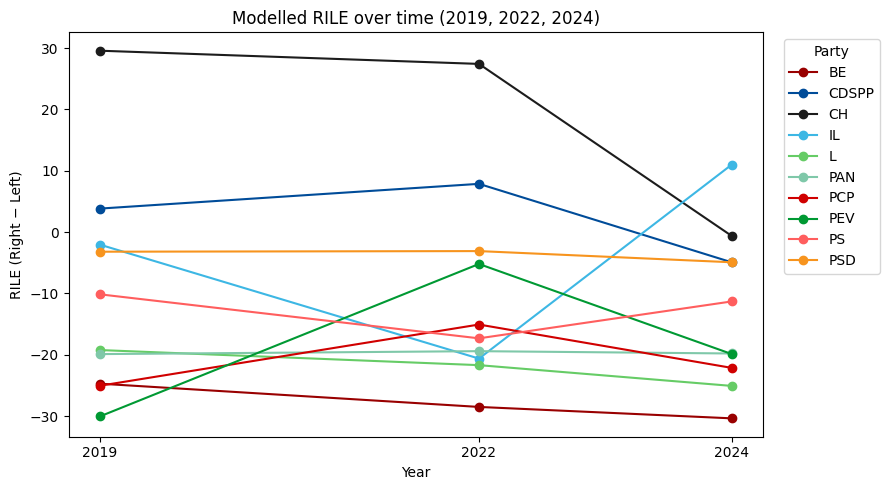

Saved: /content/_mp_pipeline/reports/rile_2019_2022_2024.png


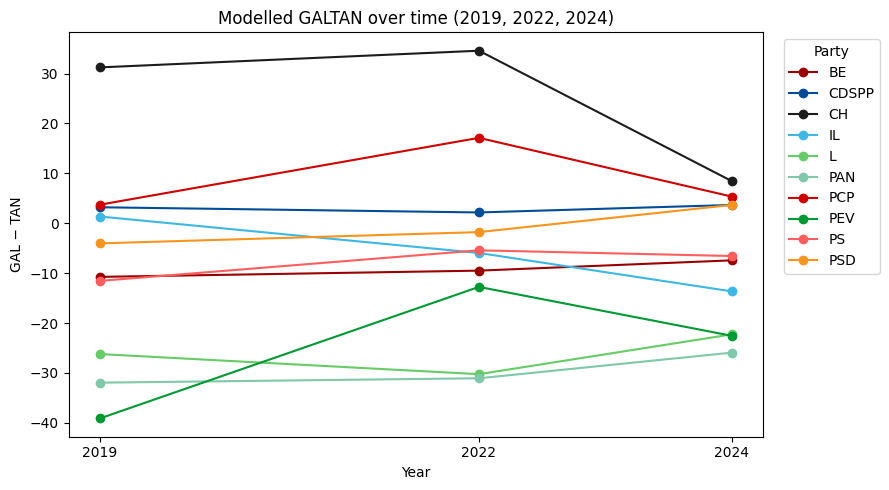

Saved: /content/_mp_pipeline/reports/galtan_2019_2022_2024.png


In [ ]:
# =========================
# VISUALIZE RILE & GALTAN (2019, 2022, 2024)
# =========================
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- config ---
BASE     = Path("/content/_mp_pipeline")
REPORTS  = BASE / "reports"
CSV_PATH = REPORTS / "all_docs_summary.csv"
#CSV_PATH = "all_docs_summary.csv"
YEARS    = {2019, 2022, 2024}   # which years to plot

# --- party color map ---
party_colors = {
    "PS":    "#FF5E5E",
    "PSD":   "#F7941E",
    "CDSPP": "#004C99",
    "BE":    "#990000",
    "PCP":   "#D00000",
    "PEV":   "#009933",
    "IL":    "#3DB7E4",
    "CH":    "#1C1C1C",
    "PAN":   "#7FC8A9",
    "L":     "#66CC66",
}

# --- load ---
df = pd.read_csv(CSV_PATH, encoding="utf-8")
# Normalize column names just in case
df.columns = [c.strip() for c in df.columns]

# --- keep only needed years & columns ---
needed_cols = {"doc_id","party","year","RILE","RILE_lo","RILE_hi","GAL_TAN"}
missing = needed_cols - set(df.columns)
if "GAL_TAN" in missing:
    print("No 'GAL_TAN' column found in all_docs_summary.csv. "
          "Add it upstream or compute it here from per-code columns (see commented template in the code).")

df = df[df["year"].isin(YEARS)].copy()

# If multiple rows per party-year exist, average them (or choose another rule)
agg = (df
       .groupby(["party","year"], as_index=False)
       .agg(
           RILE=("RILE","mean"),
           RILE_lo=("RILE_lo","mean"),
           RILE_hi=("RILE_hi","mean"),
           GAL_TAN=("GAL_TAN","mean") if "GAL_TAN" in df.columns else ("RILE","mean")
       ))

# Sort for nice plotting
agg = agg.sort_values(["party","year"])

# --- plotting helpers ---
def plot_metric_line(agg_df, metric: str, ylabel: str, title: str, outname: str):
    if metric not in agg_df.columns:
        print(f"Skip {metric}: column not available.")
        return
    plt.figure(figsize=(9,5))
    for party, g in agg_df.groupby("party"):
        g = g.sort_values("year")
        color = party_colors.get(party)  # use party-specific color if available
        plt.plot(
            g["year"],
            g[metric],
            marker="o",
            label=party,
            color=color
        )
    plt.xticks(sorted(YEARS))
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title="Party", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    outpath = REPORTS / outname
    plt.savefig(outpath, dpi=150)
    plt.show()
    print(f"Saved: {outpath}")

# --- draw charts ---
plot_metric_line(
    agg,
    "RILE",
    "RILE (Right − Left)",
    "Modelled RILE over time (2019, 2022, 2024)",
    "rile_2019_2022_2024.png"
)
plot_metric_line(
    agg,
    "GAL_TAN",
    "GAL − TAN",
    "Modelled GALTAN over time (2019, 2022, 2024)",
    "galtan_2019_2022_2024.png"
)


## Comparison With Official Scores

To contextualize the model-derived RILE and GAL–TAN estimates, this section benchmarks them against the official Manifesto Project data for Portugal. We begin by constructing a clean Portuguese-only dataset, harmonizing party abbreviations, and extracting election years from the raw MPDataset. Using this prepared dataset, we then compute official GAL–TAN values based on the predefined code and add them to the dataset. Then the evolution of RILE and GAL-TAN scores across parties and election years are visualized. This comparison provides a reference point against which the quality, direction, and plausibility of the model’s predictions can be evaluated.

### Building a Portuguese Dataset

In [ ]:
# Clean MPDataset for Portugal, fix abbreviations, and extract year correctly.

import pandas as pd
from pathlib import Path
import re

# ==== Paths ====
IN_PATH = Path("MPDataset_MPDS2025a.csv")   # adjust path if needed
OUT_PATH = Path("MPDataset_MPDS2025a_PT_clean.csv")

# ==== Load ====
mpd = pd.read_csv(IN_PATH, low_memory=False)

# Filter only for Portugal
mpd_pt = mpd[mpd["countryname"].astype(str).str.strip().eq("Portugal")].copy()

# Ensure partyabbrev exists
if "partyabbrev" not in mpd_pt.columns:
    mpd_pt["partyabbrev"] = pd.NA

# Set partyabbrev = "CH" where partyname == "Enough"
mask_enough = mpd_pt["partyname"].astype(str).str.strip().str.casefold().eq("enough")
mpd_pt.loc[mask_enough, "partyabbrev"] = "CH"

# Change CDS-PP to CDSPP
mask_cdsp = mpd_pt["partyabbrev"].astype(str).str.strip().eq("CDS-PP")
mpd_pt.loc[mask_cdsp, "partyabbrev"] = "CDSPP"

# Extract year from yyyymm-formatted 'date'
DATE_COL = "date"  # adjust if your column has a different name

def yyyymm_to_year(val):
    """Extract year from values like 199511, '199511', '199511.0', etc."""
    if pd.isna(val):
        return pd.NA
    s = str(val).strip()
    if s.endswith(".0"):
        s = s[:-2]
    try:
        n = int(s)
        return n // 100
    except ValueError:
        m = re.search(r"(\d{4})", s)
        return int(m.group(1)) if m else pd.NA

if DATE_COL not in mpd_pt.columns:
    raise ValueError(f"Expected a '{DATE_COL}' column with yyyymm values.")

mpd_pt["year"] = mpd_pt[DATE_COL].apply(yyyymm_to_year).astype("Int64")

# Save cleaned dataset
mpd_pt.to_csv(OUT_PATH, index=False)

# Print quick summary
print(f"Rows original: {len(mpd)}")
print(f"Rows for Portugal: {len(mpd_pt)}")
print(f'Rows updated to CH for "Enough": {mask_enough.sum()}')
print(f'Rows updated from CDS-PP to CDSPP: {mask_cdsp.sum()}')
print("Unique non-null years:", sorted(mpd_pt["year"].dropna().unique()))
print(f"Cleaned dataset saved to: {OUT_PATH.resolve()}")


Rows original: 5285
Rows for Portugal: 121
Rows updated to CH for "Enough": 2
Rows updated from CDS-PP to CDSPP: 8
Unique non-null years: [np.int64(1975), np.int64(1976), np.int64(1979), np.int64(1980), np.int64(1983), np.int64(1985), np.int64(1987), np.int64(1991), np.int64(1995), np.int64(1999), np.int64(2002), np.int64(2005), np.int64(2009), np.int64(2011), np.int64(2015), np.int64(2019), np.int64(2022)]
Cleaned dataset saved to: /content/MPDataset_MPDS2025a_PT_clean.csv


In [ ]:
df_official = pd.read_csv("MPDataset_MPDS2025a_PT_clean.csv")

df_official

,country,countryname,oecdmember,eumember,edate,date,party,partyname,partyabbrev,parfam,...,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm,year
0,35,Portugal,10,0,25/04/1975,197504,35210,Popular Democratic Union,UDP,20,...,NaN,NaN,-55.372,0.000,0.000,4.959,0.826,2025a,Y1GQ3J,1975
1,35,Portugal,10,0,25/04/1975,197504,35220,Portuguese Communist Party,PCP,20,...,NaN,NaN,-44.586,0.000,0.000,0.000,0.000,2025a,S7TB52,1975
2,35,Portugal,10,0,25/04/1975,197504,35310,Popular Democratic Movement,MDP,30,...,NaN,NaN,-37.879,2.273,0.758,10.606,0.000,2025a,OA17UI,1975
3,35,Portugal,10,0,25/04/1975,197504,35311,Socialist Party,PS,30,...,NaN,NaN,-58.108,4.054,0.000,0.000,2.703,2025a,FRUEBV,1975
4,35,Portugal,10,0,25/04/1975,197504,35313,Popular Democratic Party,PPD,60,...,NaN,NaN,-1.887,7.547,1.887,20.755,3.774,2025a,PI4RAA,1975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,35,Portugal,10,10,30/01/2022,202201,35311,Socialist Party,PS,30,...,1.418,0.000,-17.752,1.733,0.683,19.748,0.000,2025a,Z45GYT,2022
117,35,Portugal,10,10,30/01/2022,202201,35313,Social Democratic Party,PSD,60,...,5.895,0.043,-6.805,2.427,1.691,13.004,0.000,2025a,4S35YF,2022
118,35,Portugal,10,10,30/01/2022,202201,35410,Liberal Iniciative,IL,40,...,3.246,0.000,-9.248,5.267,6.752,15.664,0.000,2025a,CIZJLJ,2022
119,35,Portugal,10,10,30/01/2022,202201,35520,Social Democratic Center-Popular Party,CDSPP,50,...,4.615,0.000,20.000,2.564,3.077,10.256,0.000,2025a,22LRNA,2022


Adding GAL-TAN scores to the official dataframe by using the predefined GAL-TAN scores.

In [ ]:
import pandas as pd

# --- GAL–TAN per-code sets ---
GAL_CODES = {105, 106, 107, 108, 201, 202, 416, 501, 602, 604, 607}
TAN_CODES = {104, 109, 110, 305, 410, 601, 603, 605, 608}

gal_cols = [f"per{c}" for c in sorted(GAL_CODES)]
tan_cols = [f"per{c}" for c in sorted(TAN_CODES)]

# Ensure any missing perXXX columns exist (filled with 0.0)
for col in gal_cols + tan_cols:
    if col not in df_official.columns:
        df_official[col] = 0.0

# Make sure they're numeric
df_official[gal_cols + tan_cols] = (
    df_official[gal_cols + tan_cols]
    .apply(pd.to_numeric, errors="coerce")
    .fillna(0.0)
)

# Compute GAL–TAN (TAN − GAL, to match your flipped sign)
df_official["GAL_TAN"] = (
    df_official[tan_cols].sum(axis=1)
    - df_official[gal_cols].sum(axis=1)
)


In [ ]:
df_official

,country,countryname,oecdmember,eumember,edate,date,party,partyname,partyabbrev,parfam,...,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm,year,GAL_TAN
0,35,Portugal,10,0,25/04/1975,197504,35210,Popular Democratic Union,UDP,20,...,NaN,-55.372,0.000,0.000,4.959,0.826,2025a,Y1GQ3J,1975,-42.975
1,35,Portugal,10,0,25/04/1975,197504,35220,Portuguese Communist Party,PCP,20,...,NaN,-44.586,0.000,0.000,0.000,0.000,2025a,S7TB52,1975,-34.395
2,35,Portugal,10,0,25/04/1975,197504,35310,Popular Democratic Movement,MDP,30,...,NaN,-37.879,2.273,0.758,10.606,0.000,2025a,OA17UI,1975,-21.212
3,35,Portugal,10,0,25/04/1975,197504,35311,Socialist Party,PS,30,...,NaN,-58.108,4.054,0.000,0.000,2.703,2025a,FRUEBV,1975,-45.947
4,35,Portugal,10,0,25/04/1975,197504,35313,Popular Democratic Party,PPD,60,...,NaN,-1.887,7.547,1.887,20.755,3.774,2025a,PI4RAA,1975,-22.642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,35,Portugal,10,10,30/01/2022,202201,35311,Socialist Party,PS,30,...,0.000,-17.752,1.733,0.683,19.748,0.000,2025a,Z45GYT,2022,-10.977
117,35,Portugal,10,10,30/01/2022,202201,35313,Social Democratic Party,PSD,60,...,0.043,-6.805,2.427,1.691,13.004,0.000,2025a,4S35YF,2022,-4.855
118,35,Portugal,10,10,30/01/2022,202201,35410,Liberal Iniciative,IL,40,...,0.000,-9.248,5.267,6.752,15.664,0.000,2025a,CIZJLJ,2022,-9.018
119,35,Portugal,10,10,30/01/2022,202201,35520,Social Democratic Center-Popular Party,CDSPP,50,...,0.000,20.000,2.564,3.077,10.256,0.000,2025a,22LRNA,2022,10.255


### Visualization of Official Scores

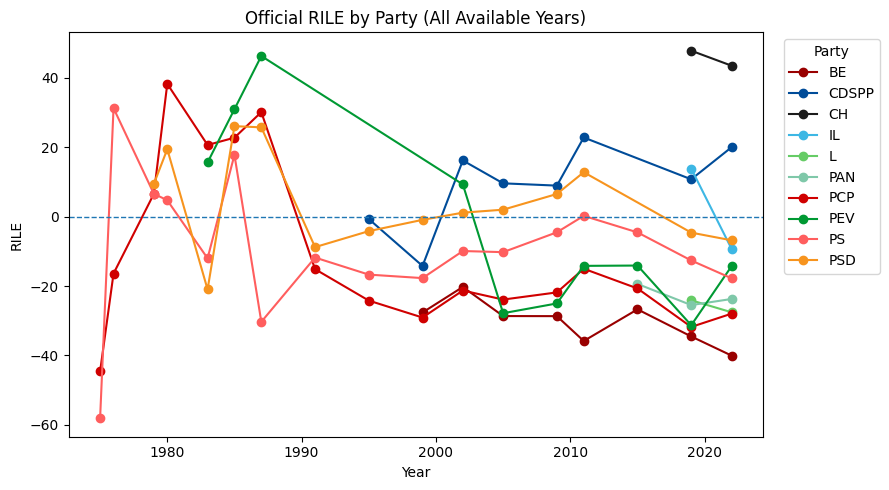

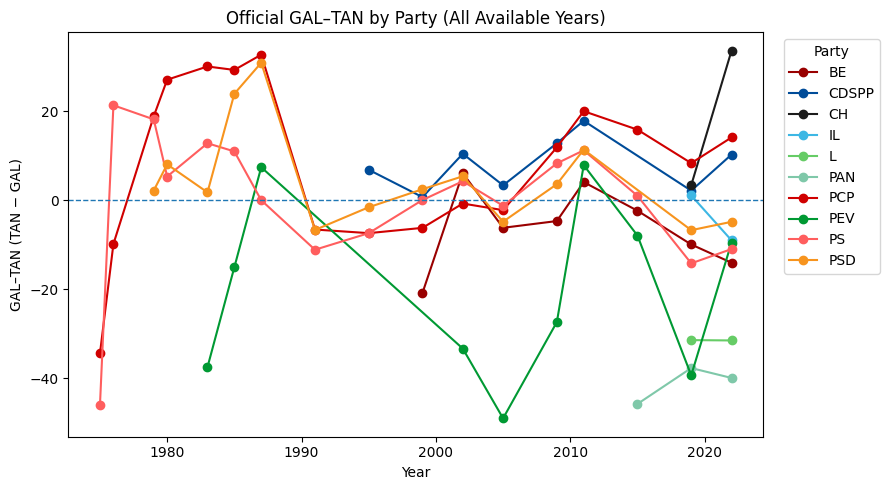

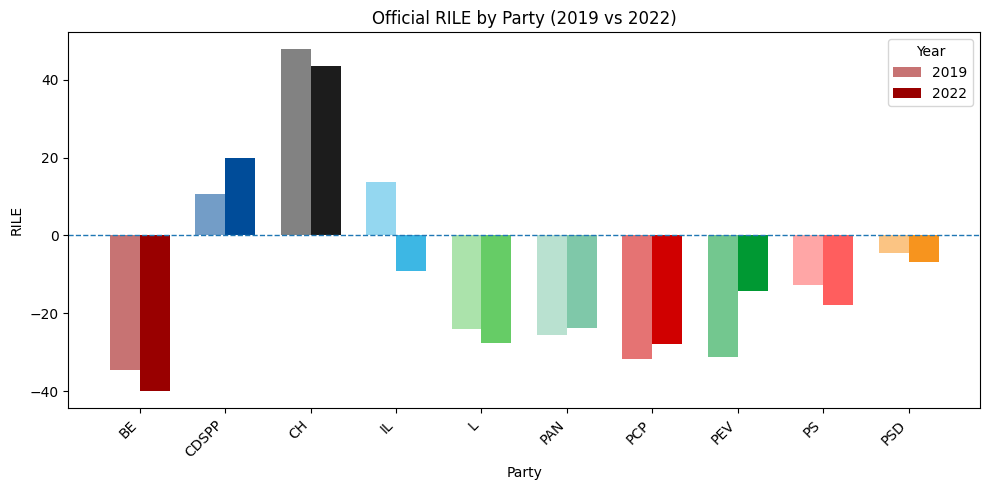

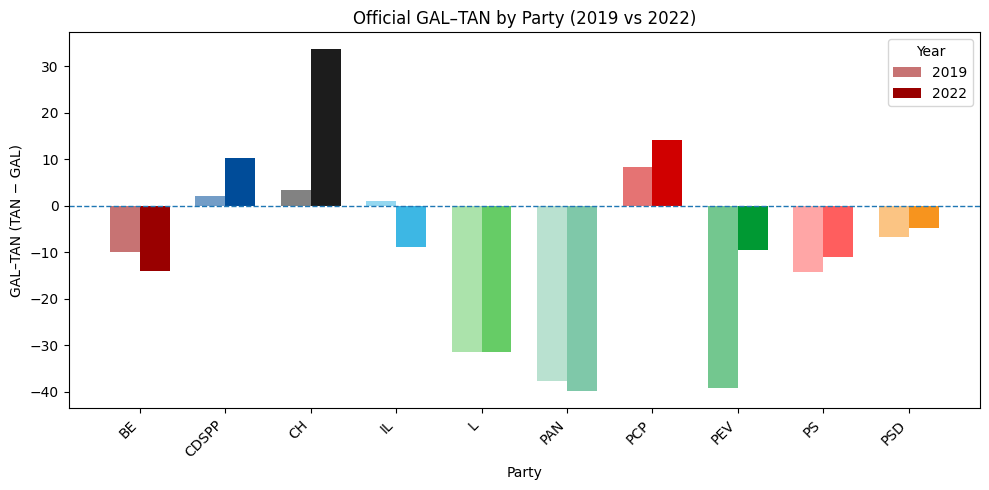

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Party Colors (BE slightly darker) ---
party_colors = {
    "PS":    "#FF5E5E",
    "PSD":   "#F7941E",
    "CDSPP": "#004C99",
    "BE":    "#990000",
    "PCP":   "#D00000",
    "PEV":   "#009933",
    "IL":    "#3DB7E4",
    "CH":    "#1C1C1C",
    "PAN":   "#7FC8A9",
    "L":     "#66CC66",
}

def lighten_color(hex_color, factor=0.55):
    """
    Lighten the given hex color by mixing it with white.
    factor = 0 → white, factor = 1 → original color.
    """
    import matplotlib.colors as mc
    rgb = mc.to_rgb(hex_color)
    return tuple(1 - (1 - c) * factor for c in rgb)


# ========= Base data prep =========

# Use already-loaded df_official
df = df_official.copy()

# Keep only the parties from the legend
parties = ["BE","CDSPP","CH","IL","L","PAN","PCP","PEV","PS","PSD"]
df = df[df["partyabbrev"].isin(parties)].copy()

# Extract election year from YYYYMM "date"
df["year"] = (df["date"] // 100).astype(int)

# Keep only what is needed (RILE + GAL_TAN)
# If some GAL_TAN are missing, we keep them and handle separately later
df = df[["partyabbrev", "year", "rile", "GAL_TAN"]]


# If multiple docs per party-year, average them (for each metric)
df_agg = (
    df
    .groupby(["partyabbrev","year"], as_index=False)
    .agg(
        rile=("rile", "mean"),
        GAL_TAN=("GAL_TAN", "mean")
    )
)


# ========= 1) ALL YEARS: line plot for RILE =========
plt.figure(figsize=(9, 5))
for p in parties:
    sub = df_agg[df_agg["partyabbrev"] == p].sort_values("year")
    if not sub.empty:
        plt.plot(
            sub["year"],
            sub["rile"],
            marker="o",
            label=p,
            color=party_colors.get(p, "#000000")  # fallback black
        )

plt.title("Official RILE by Party (All Available Years)")
plt.xlabel("Year")
plt.ylabel("RILE")
plt.axhline(0, linestyle="--", linewidth=1)
plt.legend(title="Party", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


# ========= 2) ALL YEARS: line plot for GAL_TAN =========
plt.figure(figsize=(9, 5))
for p in parties:
    sub = df_agg[df_agg["partyabbrev"] == p].sort_values("year")
    if not sub.empty:
        plt.plot(
            sub["year"],
            sub["GAL_TAN"],
            marker="o",
            label=p,
            color=party_colors.get(p, "#000000")  # same colors
        )

plt.title("Official GAL–TAN by Party (All Available Years)")
plt.xlabel("Year")
plt.ylabel("GAL–TAN (TAN − GAL)")
plt.axhline(0, linestyle="--", linewidth=1)
plt.legend(title="Party", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


# ========= 3) ONLY 2019 & 2022: grouped bars for RILE =========
years_sel = [2019, 2022]
df_2y_rile = df_agg[df_agg["year"].isin(years_sel)].copy()

# Pivot so we can plot grouped bars
pivot_rile = (
    df_2y_rile.pivot_table(index="partyabbrev", columns="year", values="rile", aggfunc="mean")
    .reindex(parties)
)

x = np.arange(len(pivot_rile.index))
width = 0.35

vals_2019_rile = pivot_rile[2019].values if 2019 in pivot_rile.columns else np.full(len(pivot_rile.index), np.nan)
vals_2022_rile = pivot_rile[2022].values if 2022 in pivot_rile.columns else np.full(len(pivot_rile.index), np.nan)

# Colors: lighter for 2019, original for 2022
colors_2022 = [party_colors[p] for p in pivot_rile.index]
colors_2019 = [lighten_color(party_colors[p], factor=0.55) for p in pivot_rile.index]

plt.figure(figsize=(10, 5))

plt.bar(x - width/2, vals_2019_rile, width, label="2019", color=colors_2019)
plt.bar(x + width/2, vals_2022_rile, width, label="2022", color=colors_2022)

plt.title("Official RILE by Party (2019 vs 2022)")
plt.xlabel("Party")
plt.ylabel("RILE")
plt.xticks(x, pivot_rile.index, rotation=45, ha="right")
plt.axhline(0, linestyle="--", linewidth=1)
plt.legend(title="Year")
plt.tight_layout()
plt.show()


# ========= 4) ONLY 2019 & 2022: grouped bars for GAL_TAN =========
df_2y_gal = df_agg[df_agg["year"].isin(years_sel)].copy()

pivot_gal = (
    df_2y_gal.pivot_table(index="partyabbrev", columns="year", values="GAL_TAN", aggfunc="mean")
    .reindex(parties)
)

x = np.arange(len(pivot_gal.index))
width = 0.35

vals_2019_gal = pivot_gal[2019].values if 2019 in pivot_gal.columns else np.full(len(pivot_gal.index), np.nan)
vals_2022_gal = pivot_gal[2022].values if 2022 in pivot_gal.columns else np.full(len(pivot_gal.index), np.nan)

# Same color logic: lighter for 2019, original for 2022
colors_2022_gal = [party_colors[p] for p in pivot_gal.index]
colors_2019_gal = [lighten_color(party_colors[p], factor=0.55) for p in pivot_gal.index]

plt.figure(figsize=(10, 5))

plt.bar(x - width/2, vals_2019_gal, width, label="2019", color=colors_2019_gal)
plt.bar(x + width/2, vals_2022_gal, width, label="2022", color=colors_2022_gal)

plt.title("Official GAL–TAN by Party (2019 vs 2022)")
plt.xlabel("Party")
plt.ylabel("GAL–TAN (TAN − GAL)")
plt.xticks(x, pivot_gal.index, rotation=45, ha="right")
plt.axhline(0, linestyle="--", linewidth=1)
plt.legend(title="Year")
plt.tight_layout()
plt.show()


## Combined Dataframe

To evaluate the performance of the model and establish a consistent basis for comparison, the official Manifesto Project scores must be combined with the model-generated scores into a single, harmonised dataset. This merged dataframe aligns party abbreviations and unifies year formats, ensuring that both sources use identical party–year identifiers. Creating this integrated dataset is essential for the subsequent calibration of the model, where modelled RILE scores are mapped onto the official scale, and it also serves as the foundation for later visualisations that compare official and predicted positions across time

In [ ]:
df_modelled = pd.read_csv("_mp_pipeline/reports/all_docs_summary.csv")

#df_modelled = pd.read_csv ("all_docs_summary.csv")

df_modelled

,doc_id,party,year,n_quasisentences,RILE,RILE_lo,RILE_hi,GAL_share,TAN_share,GAL_TAN,...,per605,per606,per607,per608,per701,per702,per703,per704,per705,per706
0,BE_2019,BE,2019,2370,-24.70,-26.72,-22.76,17.974,7.237,-10.74,...,1.743,0.126,0.535,0.134,5.106,0.149,1.267,0.411,0.480,0.757
1,CDSPP_2019,CDSPP,2019,2975,3.84,1.88,5.73,11.746,14.953,3.21,...,5.696,0.535,0.112,0.087,2.056,0.219,3.476,0.419,0.126,0.490
2,CH_2019,CH,2019,92,29.57,17.65,41.05,7.782,39.025,31.24,...,23.029,0.123,0.211,4.180,0.252,0.033,0.168,0.089,0.344,0.427
3,IL_2019,IL,2019,3426,-2.05,-3.73,-0.27,11.124,12.469,1.35,...,3.219,0.186,0.068,0.035,1.867,0.334,0.575,0.267,0.064,0.175
4,L_2019,L,2019,991,-19.22,-22.46,-16.10,35.264,9.050,-26.21,...,3.343,0.938,0.180,0.049,3.324,0.034,1.763,0.238,0.211,0.504
5,PAN_2019,PAN,2019,1780,-19.88,-22.11,-17.69,39.165,7.228,-31.94,...,5.823,0.295,0.557,0.103,2.917,0.034,1.012,0.371,0.387,0.840
6,PCP_2019,PCP,2019,2099,-25.03,-27.62,-22.63,10.741,14.475,3.73,...,3.498,0.222,0.243,0.053,9.174,0.218,1.662,0.366,0.385,0.911
7,PEV_2019,PEV,2019,233,-30.02,-35.63,-23.51,43.652,4.564,-39.09,...,0.972,0.156,0.119,0.014,0.789,0.007,3.485,0.066,0.377,0.287
8,PS_2019,PS,2019,3552,-10.14,-11.65,-8.66,22.074,10.529,-11.54,...,3.819,0.290,0.466,0.218,3.291,0.042,2.595,0.158,0.448,0.659
9,PSD_2019,PSD,2019,2066,-3.19,-5.51,-1.08,18.093,14.066,-4.03,...,4.828,0.524,0.517,0.182,1.805,0.136,2.626,0.290,0.340,0.941


In [ ]:
df_official

,country,countryname,oecdmember,eumember,edate,date,party,partyname,partyabbrev,parfam,...,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm,year,GAL_TAN
0,35,Portugal,10,0,25/04/1975,197504,35210,Popular Democratic Union,UDP,20,...,NaN,-55.372,0.000,0.000,4.959,0.826,2025a,Y1GQ3J,1975,-42.975
1,35,Portugal,10,0,25/04/1975,197504,35220,Portuguese Communist Party,PCP,20,...,NaN,-44.586,0.000,0.000,0.000,0.000,2025a,S7TB52,1975,-34.395
2,35,Portugal,10,0,25/04/1975,197504,35310,Popular Democratic Movement,MDP,30,...,NaN,-37.879,2.273,0.758,10.606,0.000,2025a,OA17UI,1975,-21.212
3,35,Portugal,10,0,25/04/1975,197504,35311,Socialist Party,PS,30,...,NaN,-58.108,4.054,0.000,0.000,2.703,2025a,FRUEBV,1975,-45.947
4,35,Portugal,10,0,25/04/1975,197504,35313,Popular Democratic Party,PPD,60,...,NaN,-1.887,7.547,1.887,20.755,3.774,2025a,PI4RAA,1975,-22.642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,35,Portugal,10,10,30/01/2022,202201,35311,Socialist Party,PS,30,...,0.000,-17.752,1.733,0.683,19.748,0.000,2025a,Z45GYT,2022,-10.977
117,35,Portugal,10,10,30/01/2022,202201,35313,Social Democratic Party,PSD,60,...,0.043,-6.805,2.427,1.691,13.004,0.000,2025a,4S35YF,2022,-4.855
118,35,Portugal,10,10,30/01/2022,202201,35410,Liberal Iniciative,IL,40,...,0.000,-9.248,5.267,6.752,15.664,0.000,2025a,CIZJLJ,2022,-9.018
119,35,Portugal,10,10,30/01/2022,202201,35520,Social Democratic Center-Popular Party,CDSPP,50,...,0.000,20.000,2.564,3.077,10.256,0.000,2025a,22LRNA,2022,10.255


In [ ]:
import pandas as pd
import numpy as np

# --- 1) Copies
off = df_official.copy()
mod = df_modelled.copy()

# --- 2) Build YEAR (robust)
# df_official has integer-like 'date' (YYYYMM or YYYYMMDD) -> take first 4 digits
off["year"] = off["date"].astype(str).str.slice(0, 4).astype(int)

# df_modelled: prefer existing 'year', else derive from 'date' similarly
if "year" in mod.columns:
    mod["year"] = pd.to_numeric(mod["year"], errors="coerce").astype("Int64")
elif "Year" in mod.columns:
    mod["year"] = pd.to_numeric(mod["Year"], errors="coerce").astype("Int64")
elif "date" in mod.columns:
    mod["year"] = mod["date"].astype(str).str.slice(0, 4).astype("Int64")
else:
    raise KeyError("df_modelled must contain 'year' or 'date' to derive year.")

# --- 3) Clean merge keys
off["party"] = off["partyabbrev"].astype(str).str.strip()
mod["party"] = mod["party"].astype(str).str.strip()

off = off.dropna(subset=["party", "year"])
mod = mod.dropna(subset=["party", "year"])

# Make sure both are plain ints for the merge
off["year"] = off["year"].astype(int)
mod["year"] = mod["year"].astype(int)

# --- 4) Keep only the columns we need
off_small = off[["party", "year", "rile", "GAL_TAN"]].rename(
    columns={
        "rile": "rile_official",
        "GAL_TAN": "galtan_official",
    }
)

mod_small = mod[["party", "year", "RILE", "GAL_TAN"]].rename(
    columns={
        "RILE": "rile_modelled",
        "GAL_TAN": "galtan_modelled",
    }
)

# If multiple observations per (party, year), average them
off_small = off_small.groupby(["party", "year"], as_index=False).agg(
    rile_official=("rile_official", "mean"),
    galtan_official=("galtan_official", "mean"),
)
mod_small = mod_small.groupby(["party", "year"], as_index=False).agg(
    rile_modelled=("rile_modelled", "mean"),
    galtan_modelled=("galtan_modelled", "mean"),
)

# --- 5) Merge (union of observed years), then keep only parties present in df_modelled
parties_from_modelled = set(mod_small["party"].unique())

merged_df = (
    pd.merge(off_small, mod_small, on=["party", "year"], how="outer")
      .query("party in @parties_from_modelled")
      .sort_values(["party", "year"], kind="mergesort")
      .reset_index(drop=True)
)

# --- 6) Ensure column order
desired_cols = [
    "party",
    "year",
    "rile_official",
    "rile_modelled",
    "galtan_official",
    "galtan_modelled",
]
merged_df = merged_df.reindex(columns=desired_cols)


merged_df.head(20)




,party,year,rile_official,rile_modelled,galtan_official,galtan_modelled
0,BE,1999,-27.604,NaN,-20.832,NaN
1,BE,2002,-20.248,NaN,6.087,NaN
2,BE,2005,-28.637,NaN,-6.198,NaN
3,BE,2009,-28.660,NaN,-4.680,NaN
4,BE,2011,-35.820,NaN,4.076,NaN
5,BE,2015,-26.703,NaN,-2.361,NaN
6,BE,2019,-34.513,-24.70,-9.942,-10.74
7,BE,2022,-40.024,-28.49,-14.043,-9.49
8,BE,2024,NaN,-30.35,NaN,-7.43
9,CDSPP,1995,-0.674,NaN,6.839,NaN


In [ ]:
# --- 7) Save to CSV
merged_df.to_csv("merged_official_modelled.csv", index=False)
print("File saved as 'merged_official_modelled.csv'")

✅ File saved as 'merged_official_modelled.csv'


## Calibration of Model Scores

To make the model-derived party positions directly comparable to the official Manifesto Project scores, this step calibrates the model outputs onto the official ideological scales. Using the merged party–year dataset, simple linear regressions are estimated for RILE and GAL–TAN on the overlapping years (2019 and 2022), treating the official scores as the dependent variable and the modelled scores as the predictor. The resulting calibration equations are then applied to all modelled observations, yielding calibrated RILE and GAL–TAN values for 2024 and 2025 that are anchored to the same metric as the historical official data.

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# ---- paths ----
in_path  = "merged_official_modelled.csv"
out_path = "merged_official_modelled_calibrated.csv"

# ---- load ----
df = pd.read_csv(in_path)

# ensure expected columns exist
needed = ["party","year","rile_official","galtan_official",
          "rile_modelled","galtan_modelled"]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns in merged file: {missing}")

# standardize types
df["party"] = df["party"].astype(str).str.strip()
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
for c in ["rile_official","galtan_official","rile_modelled","galtan_modelled"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ---- pick calibration years (2019 & 2022) ----
cal_years = [2019, 2022]
cal = df[df["year"].isin(cal_years)].copy()

# fallback: if some party-years are missing, just use any rows with both official & modelled
if cal[["rile_official","rile_modelled","galtan_official","galtan_modelled"]].dropna().empty:
    cal = df.dropna(subset=["rile_official","rile_modelled",
                            "galtan_official","galtan_modelled"]).copy()
    print("Using all overlap rows for calibration (2019/2022 not found for some entries).")

# keep only non-missing pairs
cal_rile = cal.dropna(subset=["rile_official","rile_modelled"])
cal_gal  = cal.dropna(subset=["galtan_official","galtan_modelled"])

# ---- fit linear regressions ----
def fit_lin(x, y):
    X = np.asarray(x).reshape(-1,1)
    y = np.asarray(y)
    model = LinearRegression().fit(X, y)
    r2 = model.score(X, y)
    a = float(model.intercept_)
    b = float(model.coef_[0])
    return model, a, b, r2

rile_model, a_r, b_r, r2_r = fit_lin(cal_rile["rile_modelled"], cal_rile["rile_official"])
galtan_model, a_g, b_g, r2_g = fit_lin(cal_gal["galtan_modelled"], cal_gal["galtan_official"])

print("=== Calibration results (OLS) ===")
print(f"rile_official  ≈  {a_r:+.3f}  +  {b_r:.3f} × rile_modelled     (R² = {r2_r:.3f})")
print(f"galtan_official≈  {a_g:+.3f}  +  {b_g:.3f} × galtan_modelled   (R² = {r2_g:.3f})")

# ---- apply calibration to all rows (e.g., 2024) ----
df["rile_calibrated"]   = a_r + b_r * df["rile_modelled"]
df["galtan_calibrated"] = a_g + b_g * df["galtan_modelled"]

# (optional) round for presentation
for c in ["rile_calibrated","galtan_calibrated"]:
    df[c] = df[c].round(2)

# ---- save ----
df.sort_values(["party","year"]).to_csv(out_path, index=False, encoding="utf-8")
print(f"Saved calibrated file → {out_path}")

# quick check: show 2019/2022/2024 rows
print(
    df[df["year"].isin([2019,2022,2024])]
      [["party","year","rile_official","rile_modelled","rile_calibrated",
        "galtan_official","galtan_modelled","galtan_calibrated"]]
      .head(20)
)


=== Calibration results (OLS) ===
rile_official  ≈  +4.229  +  1.427 × rile_modelled     (R² = 0.930)
galtan_official≈  -3.463  +  0.923 × galtan_modelled   (R² = 0.876)
✅ Saved calibrated file → merged_official_modelled_calibrated.csv
    party  year  rile_official  rile_modelled  rile_calibrated  \
6      BE  2019        -34.513         -24.70           -31.03   
7      BE  2022        -40.024         -28.49           -36.44   
8      BE  2024            NaN         -30.35           -39.10   
15  CDSPP  2019         10.767           3.84             9.71   
16  CDSPP  2022         20.000           7.87            15.46   
17  CDSPP  2024            NaN          -4.91            -2.78   
18     CH  2019         47.822          29.57            46.44   
19     CH  2022         43.511          27.42            43.37   
20     CH  2024            NaN          -0.60             3.37   
21     IL  2019         13.853          -2.05             1.30   
22     IL  2022         -9.248        

### Visualizations of Calibrated Scores


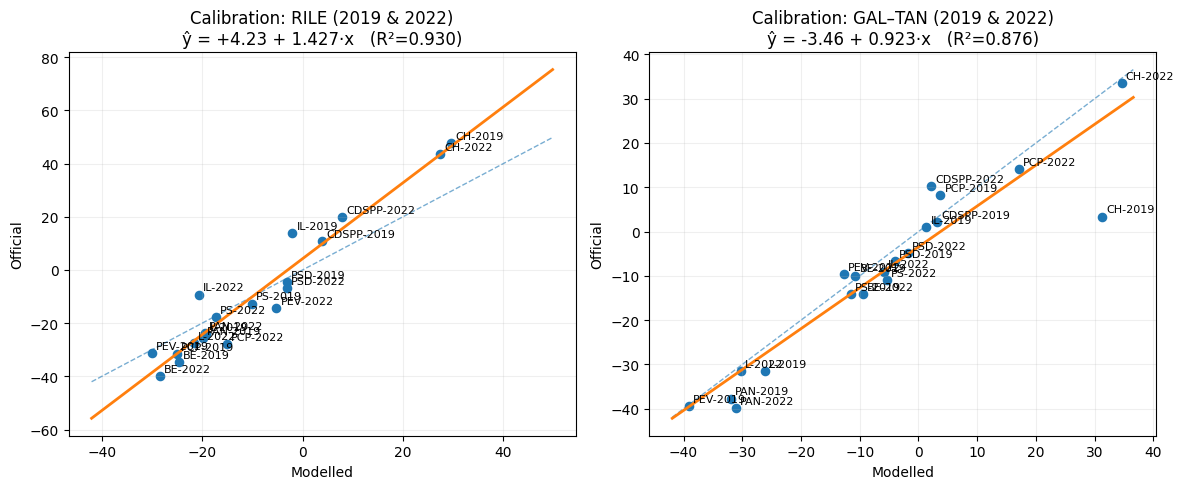

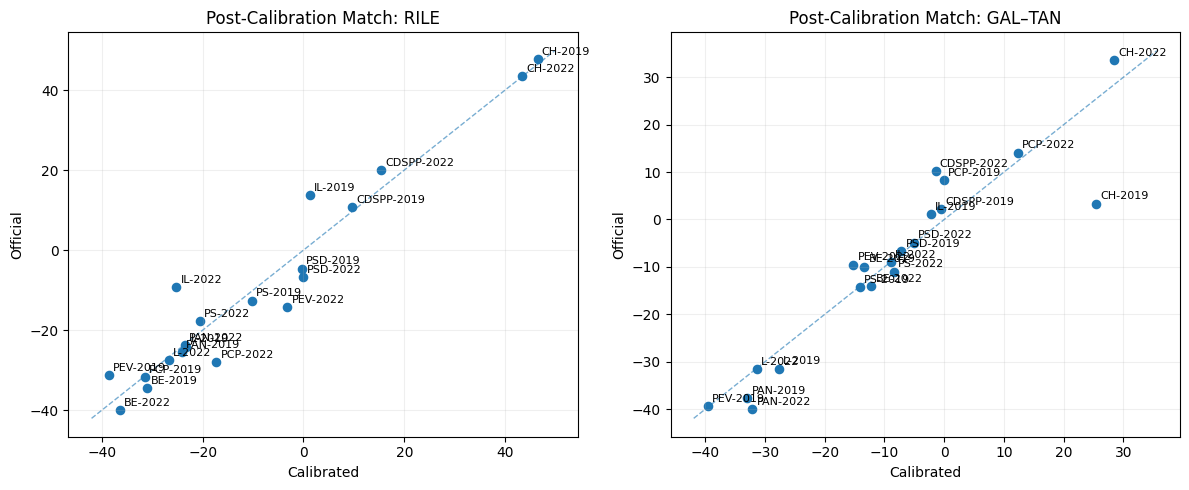

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# === Paths ===
path = "merged_official_modelled_calibrated.csv"    # final merged file
df = pd.read_csv(path)

# Ensure numeric
for c in ["rile_official", "galtan_official",
          "rile_modelled", "galtan_modelled",
          "rile_calibrated", "galtan_calibrated",
          "year"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ===== 1) SCATTER: Calibration fit on overlap years (2019 & 2022) =====
cal = df[df["year"].isin([2019, 2022])].copy()

def fit_and_plot(ax, xcol, ycol, title, party_col="party"):
    sub = cal.dropna(subset=[xcol, ycol]).copy()
    X = sub[[xcol]].values
    y = sub[ycol].values

    # Fit OLS (modelled → official)
    reg = LinearRegression().fit(X, y)
    a, b = reg.intercept_, reg.coef_[0]
    r2 = reg.score(X, y)

    # Scatter
    ax.scatter(sub[xcol], sub[ycol], s=35)

    # Annotate party-year
    if party_col in sub.columns:
        for _, r in sub.iterrows():
            ax.annotate(f"{r[party_col]}-{int(r['year'])}",
                        (r[xcol], r[ycol]),
                        fontsize=8,
                        xytext=(3,3),
                        textcoords="offset points")

    # 45° reference line
    lo = np.nanmin([sub[xcol].min(), sub[ycol].min()]) - 2
    hi = np.nanmax([sub[xcol].max(), sub[ycol].max()]) + 2
    ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1, alpha=0.6)

    # Regression line
    xs = np.linspace(lo, hi, 100)
    ax.plot(xs, a + b * xs, linewidth=2)

    ax.set_title(f"{title}\nŷ = {a:+.2f} + {b:.3f}·x   (R²={r2:.3f})")
    ax.set_xlabel("Modelled")
    ax.set_ylabel("Official")
    ax.grid(alpha=0.2)


fig, axes = plt.subplots(1, 2, figsize=(12,5))
fit_and_plot(axes[0], "rile_modelled",   "rile_official",   "Calibration: RILE (2019 & 2022)")
fit_and_plot(axes[1], "galtan_modelled", "galtan_official", "Calibration: GAL–TAN (2019 & 2022)")
plt.tight_layout()
plt.show()


# ===== 2) SCATTER: After calibration (all available overlap years) =====
def compare_calibrated(ax, calcol, offcol, title, party_col="party"):
    sub = df.dropna(subset=[calcol, offcol]).copy()

    ax.scatter(sub[calcol], sub[offcol], s=35)

    # Annotate party-year
    if party_col in sub.columns:
        for _, r in sub.iterrows():
            ax.annotate(f"{r[party_col]}-{int(r['year'])}",
                        (r[calcol], r[offcol]),
                        fontsize=8,
                        xytext=(3,3),
                        textcoords="offset points")

    lo = np.nanmin([sub[calcol].min(), sub[offcol].min()]) - 2
    hi = np.nanmax([sub[calcol].max(), sub[offcol].max()]) + 2

    # Ideal line y=x
    ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1, alpha=0.6)

    ax.set_title(title)
    ax.set_xlabel("Calibrated")
    ax.set_ylabel("Official")
    ax.grid(alpha=0.2)


fig, axes = plt.subplots(1, 2, figsize=(12,5))
compare_calibrated(axes[0], "rile_calibrated",   "rile_official",   "Post-Calibration Match: RILE")
compare_calibrated(axes[1], "galtan_calibrated", "galtan_official", "Post-Calibration Match: GAL–TAN")
plt.tight_layout()
plt.show()


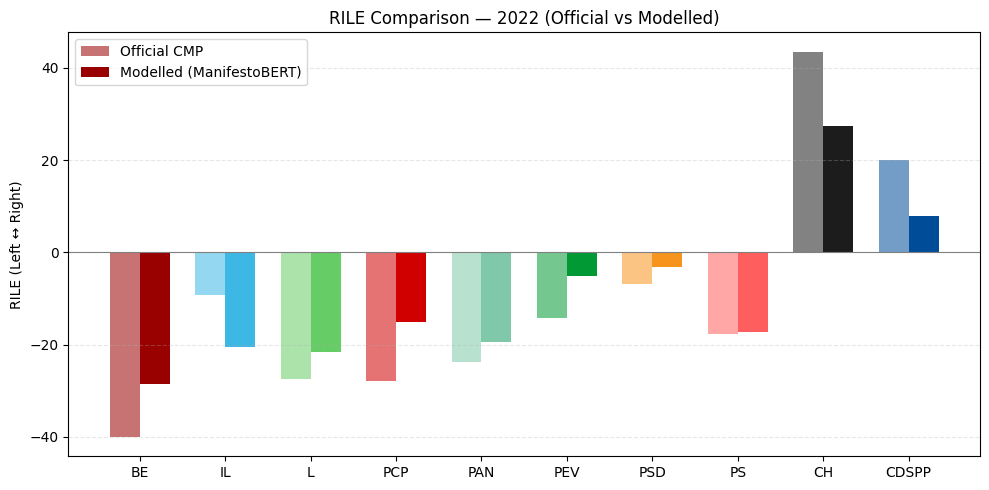

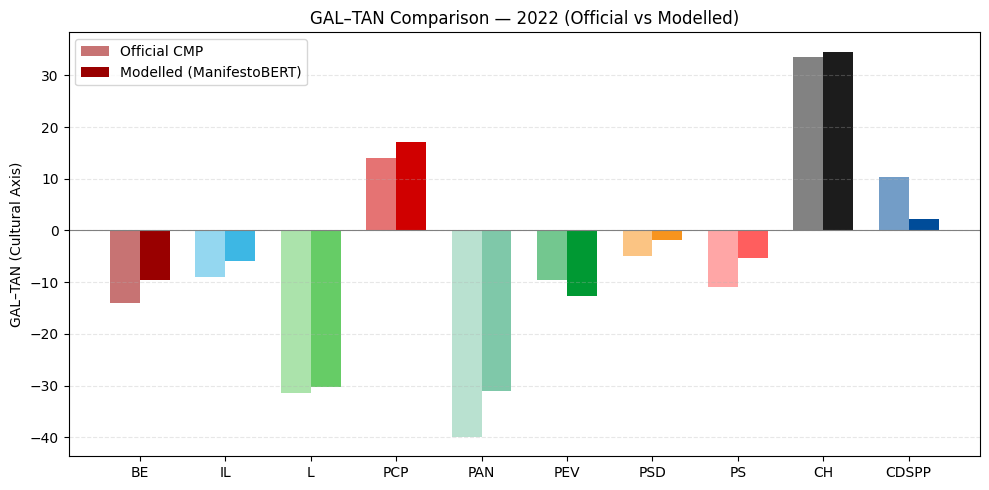

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mc

# === 0) Party color map (10 parties) ===
party_colors = {
    "PS":    "#FF5E5E",
    "PSD":   "#F7941E",
    "CDSPP": "#004C99",
    "BE":    "#990000",
    "PCP":   "#D00000",
    "PEV":   "#009933",
    "IL":    "#3DB7E4",
    "CH":    "#1C1C1C",
    "PAN":   "#7FC8A9",
    "L":     "#66CC66",
}

# Helper to lighten colors
def lighten_color(hex_color, factor=0.55):
    """
    Lighten a hex color by mixing with white.
    factor = 0 → white, factor = 1 → original color.
    """
    rgb = mc.to_rgb(hex_color)
    return tuple(1 - (1 - c) * factor for c in rgb)


# === Load data ===
df = pd.read_csv("merged_official_modelled_calibrated.csv")

# Ensure numeric
for c in ["rile_official", "rile_modelled", "galtan_official", "galtan_modelled"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Fix party naming consistency
df["party"] = df["party"].replace({"CDS-PP": "CDSPP"})

# === Filter to 2022 and target parties ===
parties = ["BE", "IL", "L", "PCP", "PAN", "PEV", "PSD", "PS", "CH", "CDSPP"]
df_22 = df[(df["year"] == 2022) & (df["party"].isin(parties))].copy()

# Sort by party
df_22["party"] = pd.Categorical(df_22["party"], categories=parties, ordered=True)
df_22 = df_22.sort_values("party")

x = np.arange(len(df_22))
width = 0.35

# Precompute colors
colors_dark = [party_colors[p] for p in df_22["party"]]
colors_light = [lighten_color(party_colors[p], factor=0.55) for p in df_22["party"]]


# === 1) RILE: Official (light) vs Modelled (dark) ===
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(x - width/2, df_22["rile_official"], width,
       label="Official CMP", color=colors_light)

ax.bar(x + width/2, df_22["rile_modelled"], width,
       label="Modelled (ManifestoBERT)", color=colors_dark)

ax.set_title("RILE Comparison — 2022 (Official vs Modelled)")
ax.set_ylabel("RILE (Left ↔ Right)")
ax.set_xticks(x)
ax.set_xticklabels(df_22["party"])
ax.axhline(0, color="gray", linewidth=0.8)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


# === 2) GAL–TAN: Official (light) vs Modelled (dark) ===
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(x - width/2, df_22["galtan_official"], width,
       label="Official CMP", color=colors_light)

ax.bar(x + width/2, df_22["galtan_modelled"], width,
       label="Modelled (ManifestoBERT)", color=colors_dark)

ax.set_title("GAL–TAN Comparison — 2022 (Official vs Modelled)")
ax.set_ylabel("GAL–TAN (Cultural Axis)")
ax.set_xticks(x)
ax.set_xticklabels(df_22["party"])
ax.axhline(0, color="gray", linewidth=0.8)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


### Evaluation of Calibration

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

YEARS = [2019, 2022]

def compute_metrics(df_year, off_col, pred_col):
    d = df_year[[off_col, pred_col]].dropna()
    if d.empty:
        return np.nan, np.nan, 0
    mae = mean_absolute_error(d[off_col], d[pred_col])
    rmse = np.sqrt(mean_squared_error(d[off_col], d[pred_col]))
    n = len(d)
    return mae, rmse, n

rows = []

for yr in YEARS:
    d = df[df["year"] == yr].copy()

    # RILE
    mae_raw_rile, rmse_raw_rile, n_raw_rile = compute_metrics(d, "rile_official", "rile_modelled")
    mae_cal_rile, rmse_cal_rile, n_cal_rile = compute_metrics(d, "rile_official", "rile_calibrated")

    # GAL-TAN
    mae_raw_gt, rmse_raw_gt, n_raw_gt = compute_metrics(d, "galtan_official", "galtan_modelled")
    mae_cal_gt, rmse_cal_gt, n_cal_gt = compute_metrics(d, "galtan_official", "galtan_calibrated")

    rows.append({
        "year": yr,

        "MAE RILE (raw)": mae_raw_rile,
        "RMSE RILE (raw)": rmse_raw_rile,
        "N RILE (raw)": n_raw_rile,

        "MAE RILE (calibrated)": mae_cal_rile,
        "RMSE RILE (calibrated)": rmse_cal_rile,
        "N RILE (calibrated)": n_cal_rile,

        "MAE GAL-TAN (raw)": mae_raw_gt,
        "RMSE GAL-TAN (raw)": rmse_raw_gt,
        "N GAL-TAN (raw)": n_raw_gt,

        "MAE GAL-TAN (calibrated)": mae_cal_gt,
        "RMSE GAL-TAN (calibrated)": rmse_cal_gt,
        "N GAL-TAN (calibrated)": n_cal_gt,
    })

metrics_table = pd.DataFrame(rows)

metrics_table


,year,MAE RILE (raw),RMSE RILE (raw),N RILE (raw),MAE RILE (calibrated),RMSE RILE (calibrated),N RILE (calibrated),MAE GAL-TAN (raw),RMSE GAL-TAN (raw),N GAL-TAN (raw),MAE GAL-TAN (calibrated),RMSE GAL-TAN (calibrated),N GAL-TAN (calibrated)
0,2019,7.3252,9.167985,10,3.4942,5.031314,10,5.1183,9.353107,10,4.9011,7.879395,10
1,2022,8.7433,9.919656,10,5.6419,7.596563,10,4.1721,4.865354,10,3.6907,5.195143,10


## Visualizations

This section visualizes RILE scores, GAL-TAN scores and the political compass bpth over the full availble time period constructed from official and calibrated scores, as well as a shorter time periood from 2011 - 2025 which will be used to analyze the recent trends in the Portuguese political landscape

### RILE

**Right-coded categories:**
per104 (Military: Positive), per201 (Freedom and Human Rights), per203 (Constitutionalism: Positive), per305 (Political Authority), per401 (Free Market Economy), per402 (Incentives: Positive), per407 (Protectionism: Negative), per414 (Economic Orthodoxy), per505 (Welfare State Limitation), per601 (National Way of Life: Positive), per603 (Traditional Morality: Positive), per605 (Law and Order), per606 (Civic Mindedness: Positive).


**Left-coded categories:**
per103 (Anti-Imperialism), per105 (Military: Negative), per106 (Peace), per107 (Internationalism: Positive), per403 (Market Regulation), per404 (Economic Planning), per406 (Protectionism: Positive), per412 (Controlled Economy), per413 (Nationalisation), per504 (Welfare State Expansion), per506 (Education Expansion), per701 (Labour Groups: Positive), per202 (Democracy).


**Full Time Range**

Modelled RILE scores start in 2024


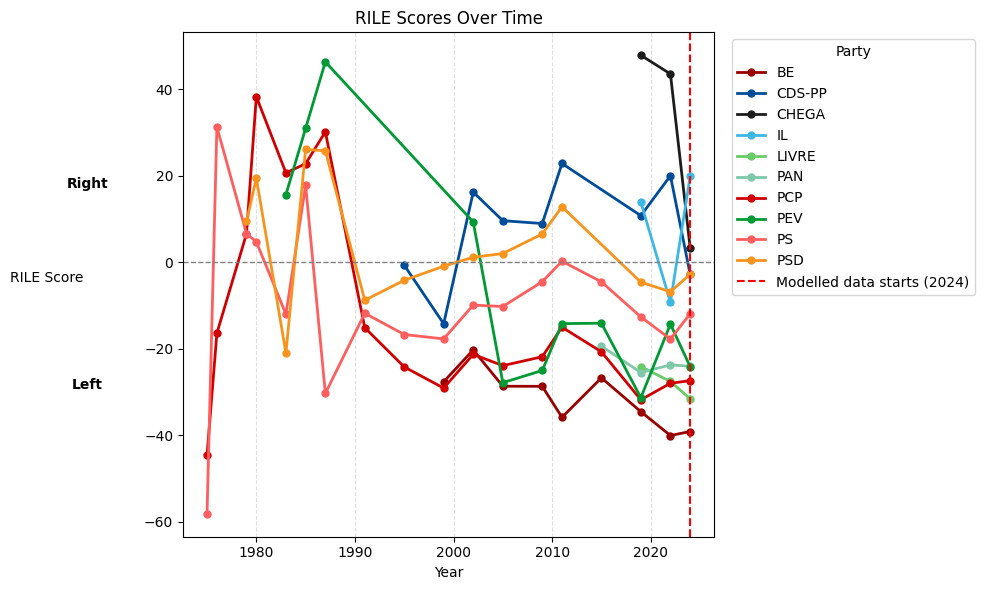

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === 0) Party color map (10 parties) ===
party_colors = {
    "PS":    "#FF5E5E",
    "PSD":   "#F7941E",
    "CDS-PP": "#004C99",
    "BE":    "#990000",
    "PCP":   "#D00000",
    "PEV":   "#009933",
    "IL":    "#3DB7E4",
    "CHEGA":    "#1C1C1C",
    "PAN":   "#7FC8A9",
    "LIVRE":     "#66CC66",
}
# --- Start from your df ---
data = df.copy()

# Normalize party labels so colors match even if aliases are used
name_map = {"L": "LIVRE", "CH": "CHEGA", "CDSPP": "CDS-PP"}
data["party"] = data["party"].replace(name_map).astype(str).str.strip()

# Optional: keep only the 10 parties we have colors for
target_parties = list(party_colors.keys())
data = data[data["party"].isin(target_parties)]

# --- 1) Combined RILE: prefer official, fallback to modelled
data["rile_combined"] = data["rile_official"].combine_first(data["rile_calibrated"])

# --- 2) First year where modelled values kick in
first_modelled_year = (
    data.loc[data["rile_official"].isna() & data["rile_calibrated"].notna(), "year"].min()
)
print(f"Modelled RILE scores start in {first_modelled_year}")

# --- 3) Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Vertical gridlines
plt.grid(axis="x", linestyle="--", alpha=0.4)

parties = sorted(data["party"].unique())
for p in parties:
    sub = data[data["party"] == p].sort_values("year")
    if sub.empty:
        continue
    ax.plot(
        sub["year"],
        sub["rile_combined"],
        marker="o",
        linewidth=2,
        markersize=5,
        label=p,
        color=party_colors.get(p)  # apply party color
    )

# Vertical line where modelled values start
if not np.isnan(first_modelled_year):
    vlabel = f"Modelled data starts ({int(first_modelled_year)})"
    ax.axvline(first_modelled_year, color="red", linestyle="--", linewidth=1.5, label=vlabel)

# --- Titles & axis labels ---
ax.set_title("RILE Scores Over Time")
ax.set_xlabel("Year")

# Make y-label horizontal and far left (so it's the left-most label)
ax.set_ylabel("RILE Score", rotation=0, labelpad=70)

# Zero line
ax.axhline(0, color="gray", linestyle="--", linewidth=1)

# --- Place "Right" and "Left" between y-label and plot ---
# x < 0 is left of the plot; we pick a value a bit to the right of the y-label
x_text = -0.18

# Use axis coordinates for y positions (0 = bottom, 1 = top)
ax.text(
    x_text, 0.70, "Right",
    transform=ax.transAxes,
    ha="center", va="center",
    fontweight="bold"
)
ax.text(
    x_text, 0.30, "Left",
    transform=ax.transAxes,
    ha="center", va="center",
    fontweight="bold"
)

# --- Legend ordering ---
handles, labels = ax.get_legend_handles_labels()
ordered = [(h, l) for h, l in zip(handles, labels) if "Modelled data starts" not in l]
vline = [(h, l) for h, l in zip(handles, labels) if "Modelled data starts" in l]
if ordered or vline:
    handles, labels = zip(*(ordered + vline))
    ax.legend(handles, labels, title="Party", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


**2011-2024**

Modelled RILE scores start in 2024


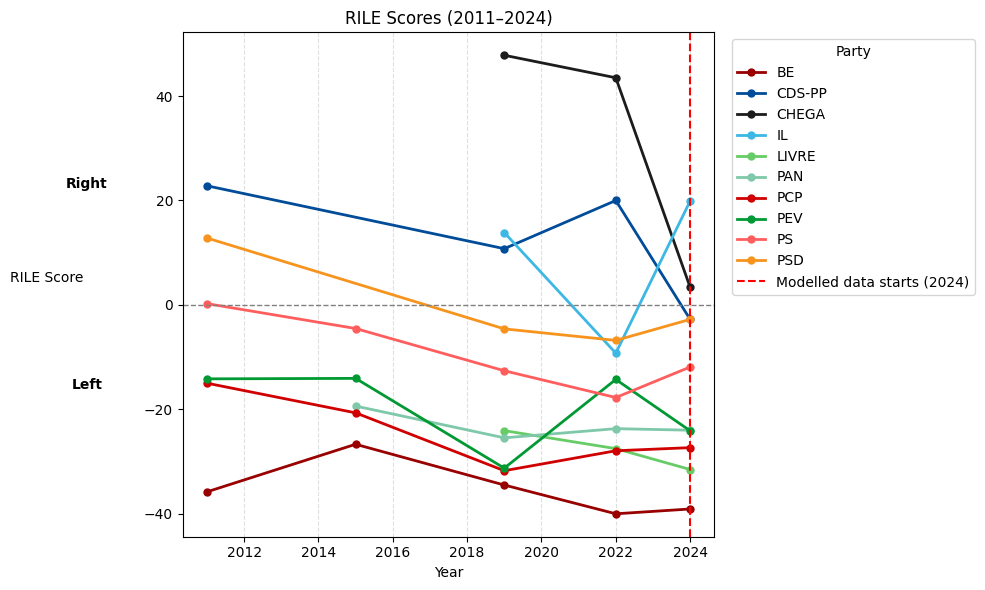

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === 0) Party color map (10 parties) ===
party_colors = {
    "PS":    "#FF5E5E",
    "PSD":   "#F7941E",
    "CDS-PP": "#004C99",
    "BE":    "#990000",
    "PCP":   "#D00000",
    "PEV":   "#009933",
    "IL":    "#3DB7E4",
    "CHEGA":    "#1C1C1C",
    "PAN":   "#7FC8A9",
    "LIVRE":     "#66CC66",
}

# --- Start from df ---
data = df.copy()

# Normalize party labels so colors match even if aliases are used
name_map = {"L": "LIVRE", "CH": "CHEGA", "CDSPP": "CDS-PP"}
data["party"] = data["party"].replace(name_map).astype(str).str.strip()

# Keep only the 10 parties we have colors for
target_parties = list(party_colors.keys())
data = data[data["party"].isin(target_parties)]

# --- 1) Create combined RILE (prefer official, fallback to modelled)
data["rile_combined"] = data["rile_official"].combine_first(data["rile_calibrated"])

# --- 2) Filter only years 2011–2024
data = data[(data["year"] >= 2011) & (data["year"] <= 2024)]

# --- 3) Find where modelled data starts
first_modelled_year = (
    data.loc[data["rile_official"].isna() & data["rile_calibrated"].notna(), "year"].min()
)
print(f"Modelled RILE scores start in {first_modelled_year}")

# --- 4) Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Vertical gridlines
plt.grid(axis="x", linestyle="--", alpha=0.4)

parties = sorted(data["party"].unique())
for p in parties:
    sub = data[data["party"] == p].sort_values("year")
    if sub.empty:
        continue
    ax.plot(
        sub["year"],
        sub["rile_combined"],
        marker="o",
        linewidth=2,
        markersize=5,
        label=p,
        color=party_colors.get(p)
    )

# Add vertical line where modelled values start
if not np.isnan(first_modelled_year):
    vlabel = f"Modelled data starts ({int(first_modelled_year)})"
    ax.axvline(first_modelled_year, color="red", linestyle="--", linewidth=1.5, label=vlabel)

# --- Titles & axis labels ---
ax.set_title("RILE Scores (2011–2024)")
ax.set_xlabel("Year")

# Horizontal y-label, pushed left so it's the left-most label
ax.set_ylabel("RILE Score", rotation=0, labelpad=70)

# Zero line
ax.axhline(0, color="gray", linestyle="--", linewidth=1)

# --- "Right" and "Left" labels between y-label and plot ---
x_text = -0.18

ax.text(
    x_text, 0.70, "Right",
    transform=ax.transAxes,
    ha="center", va="center",
    fontweight="bold"
)
ax.text(
    x_text, 0.30, "Left",
    transform=ax.transAxes,
    ha="center", va="center",
    fontweight="bold"
)

# --- Legend ordering (parties first, then modelled marker) ---
handles, labels = ax.get_legend_handles_labels()
ordered = [(h, l) for h, l in zip(handles, labels) if "Modelled data starts" not in l]
vline = [(h, l) for h, l in zip(handles, labels) if "Modelled data starts" in l]
if ordered or vline:
    handles, labels = zip(*(ordered + vline))
    ax.legend(handles, labels, title="Party", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


### GAL-TAN

**TAN-coded categories:**
per104 (Military: Positive), per109 (Internationalism: Negative), per110 (European Community/Union: Negative), per305 (Political Authority), per410 (Economic Growth: Positive), per601 (National Way of Life: Positive), per603 (Traditional Morality: Positive),
per605 (Law and Order: Positive), per608 (Multiculturalism: Negative).


**GAL-coded categories:**
per105 (Military: Negative), per106 (Peace), per107 (Internationalism: Positive), per108 (European Community/Union: Positive), per201 (Freedom and Human Rights), per202 (Democracy), per416 (Anti-Growth Economy: Positive), per501 (Environmental Protection), per602 (National Way of Life: Negative), per604 (Traditional Morality: Negative), per607 (Multiculturalism: Positive).


**Full Time Range**

Modelled GALTAN scores start in 2024


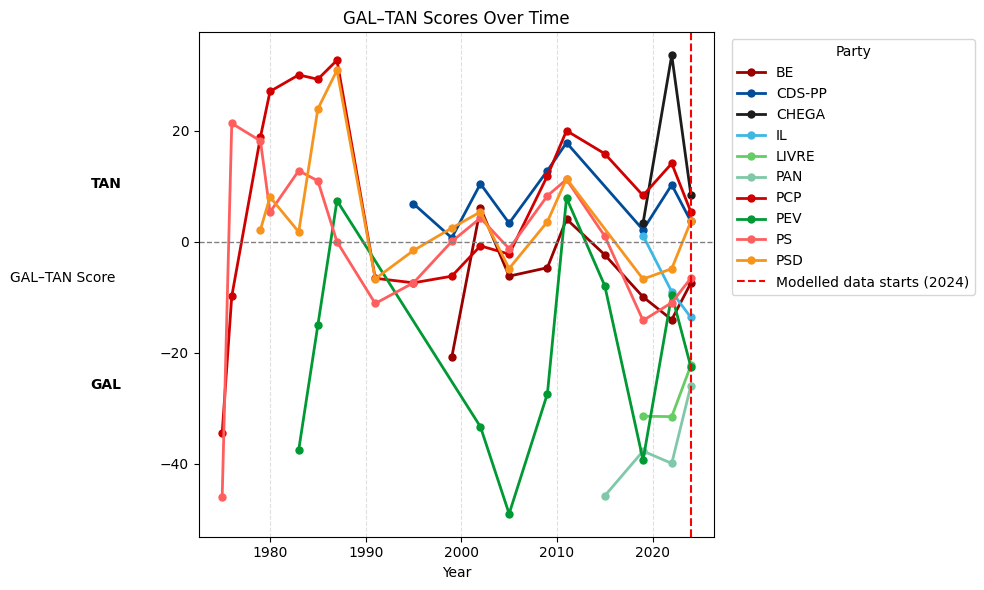

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === 0) Party color map (10 parties) ===
party_colors = {
    "PS":    "#FF5E5E",
    "PSD":   "#F7941E",
    "CDS-PP": "#004C99",
    "BE":    "#990000",
    "PCP":   "#D00000",
    "PEV":   "#009933",
    "IL":    "#3DB7E4",
    "CHEGA":    "#1C1C1C",
    "PAN":   "#7FC8A9",
    "LIVRE":     "#66CC66",
}


# --- Start from df ---
data = df.copy()

# Normalize party labels so colors match even if aliases are used
name_map = {"L": "LIVRE", "CH": "CHEGA", "CDSPP": "CDS-PP"}
data["party"] = data["party"].replace(name_map).astype(str).str.strip()

# Keep only mapped parties
target_parties = list(party_colors.keys())
data = data[data["party"].isin(target_parties)]

# --- 1) Combined GAL–TAN score (prefer official)
data["galtan_combined"] = data["galtan_official"].combine_first(data["galtan_modelled"])

# --- 2) First year using modelled values
first_modelled_year = (
    data.loc[data["galtan_official"].isna() & data["galtan_modelled"].notna(), "year"].min()
)
print(f"Modelled GALTAN scores start in {first_modelled_year}")

# --- 3) Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Vertical gridlines
plt.grid(axis="x", linestyle="--", alpha=0.4)

parties = sorted(data["party"].unique())
for p in parties:
    sub = data[data["party"] == p].sort_values("year")
    if sub.empty:
        continue
    ax.plot(
        sub["year"],
        sub["galtan_combined"],
        marker="o",
        linewidth=2,
        markersize=5,
        label=p,
        color=party_colors.get(p)
    )

# Vertical line: modelled data starts
if not np.isnan(first_modelled_year):
    ax.axvline(first_modelled_year, color="red", linestyle="--", linewidth=1.5,
               label=f"Modelled data starts ({int(first_modelled_year)})")

# --- Titles & axis labels ---
ax.set_title("GAL–TAN Scores Over Time")
ax.set_xlabel("Year")

# Horizontal y-label FAR LEFT
ax.set_ylabel("GAL–TAN Score", rotation=0, labelpad=70)

# Zero line
ax.axhline(0, color="gray", linestyle="--", linewidth=1)

# --- Place TAN (top) and GAL (bottom) LEFT of the plot but right of the y-label ---
x_text = -0.18

ax.text(
    x_text, 0.70, "TAN",
    transform=ax.transAxes,
    ha="center", va="center",
    fontweight="bold"
)
ax.text(
    x_text, 0.30, "GAL",
    transform=ax.transAxes,
    ha="center", va="center",
    fontweight="bold"
)

# --- Legend ordering (parties first, modelled marker last) ---
handles, labels = ax.get_legend_handles_labels()
ordered = [(h, l) for h, l in zip(handles, labels) if "Modelled data starts" not in l]
vline = [(h, l) for h, l in zip(handles, labels) if "Modelled data starts" in l]
if ordered or vline:
    handles, labels = zip(*(ordered + vline))
    ax.legend(handles, labels, title="Party",
              bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


**2011-2024**

Modelled GALTAN scores start in 2024


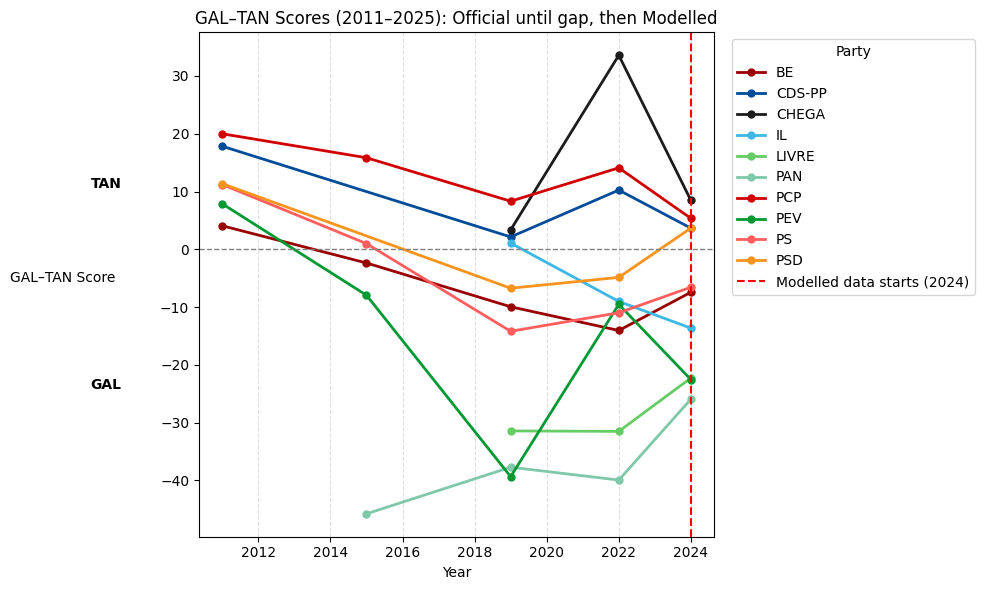

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Load data ===
df = pd.read_csv("merged_official_modelled_calibrated.csv")

# === 0) Party color map (10 parties) ===
party_colors = {
    "PS":    "#FF5E5E",
    "PSD":   "#F7941E",
    "CDS-PP": "#004C99",
    "BE":    "#990000",
    "PCP":   "#D00000",
    "PEV":   "#009933",
    "IL":    "#3DB7E4",
    "CHEGA":    "#1C1C1C",
    "PAN":   "#7FC8A9",
    "LIVRE":     "#66CC66",
}


# --- Start from df ---
data = df.copy()

# Normalize party labels so colors match
name_map = {"L": "LIVRE", "CH": "CHEGA", "CDSPP": "CDS-PP"}
data["party"] = data["party"].replace(name_map).astype(str).str.strip()

# Keep only mapped parties
data = data[data["party"].isin(party_colors.keys())]

# --- 1) Create combined GAL–TAN score
data["galtan_combined"] = data["galtan_official"].combine_first(data["galtan_modelled"])

# --- 2) Filter 2011–2025
data = data[(data["year"] >= 2011) & (data["year"] <= 2025)]

# --- 3) Find first year with modelled values
first_modelled_year = (
    data.loc[data["galtan_official"].isna() & data["galtan_modelled"].notna(), "year"].min()
)
print(f"Modelled GALTAN scores start in {first_modelled_year}")

# --- 4) Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Vertical gridlines
plt.grid(axis="x", linestyle="--", alpha=0.4)

# Plot each party
parties = sorted(data["party"].unique())
for p in parties:
    sub = data[data["party"] == p].sort_values("year")
    if not sub.empty:
        ax.plot(
            sub["year"],
            sub["galtan_combined"],
            marker="o",
            linewidth=2,
            markersize=5,
            label=p,
            color=party_colors.get(p)
        )

# Add line where modelled data starts
if not np.isnan(first_modelled_year):
    ax.axvline(first_modelled_year, color="red", linestyle="--", linewidth=1.5,
               label=f"Modelled data starts ({int(first_modelled_year)})")

# --- Titles & axis labels ---
ax.set_title("GAL–TAN Scores (2011–2025): Official until gap, then Modelled")
ax.set_xlabel("Year")

# Horizontal y-label placed far left
ax.set_ylabel("GAL–TAN Score", rotation=0, labelpad=70)

# Zero line
ax.axhline(0, color="gray", linestyle="--", linewidth=1)

# --- TAN and GAL labels between y-label and plot ---
x_text = -0.18

ax.text(
    x_text, 0.70, "TAN",
    transform=ax.transAxes,
    ha="center", va="center",
    fontweight="bold"
)
ax.text(
    x_text, 0.30, "GAL",
    transform=ax.transAxes,
    ha="center", va="center",
    fontweight="bold"
)

# --- Legend ordering (parties first, then modelled marker) ---
handles, labels = ax.get_legend_handles_labels()
ordered = [(h, l) for h, l in zip(handles, labels) if "Modelled" not in l]
vline = [(h, l) for h, l in zip(handles, labels) if "Modelled" in l]

if ordered or vline:
    handles, labels = zip(*(ordered + vline))
    ax.legend(handles, labels, title="Party",
              bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


### Political Compass

To complement the one-dimensional analyses of economic (RILE) and cultural (GAL–TAN) positioning, this section introduces a two-dimensional political compass. Plotting parties simultaneously on the left–right and GAL–TAN axes provides a more holistic representation of their ideological profiles, capturing cross-cutting patterns that a single dimension cannot fully reveal. This visualization is included to show how parties cluster or diverge across both dimensions at once and identify multidimensional ideological shifts over time.

**2011 - 2025**

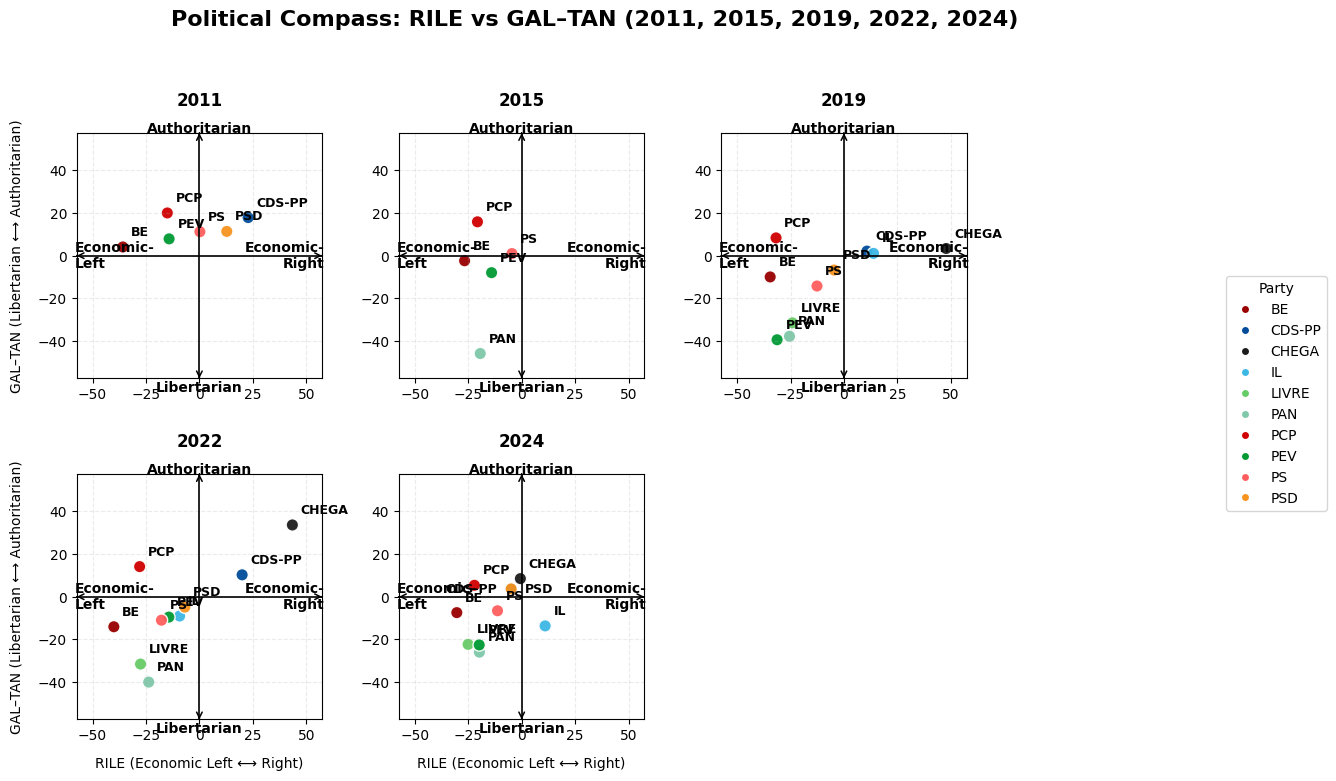

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# === Party color map (10 parties) ===
party_colors = {
    "PS":    "#FF5E5E",
    "PSD":   "#F7941E",
    "CDS-PP": "#004C99",
    "BE":    "#990000",
    "PCP":   "#D00000",
    "PEV":   "#009933",
    "IL":    "#3DB7E4",
    "CHEGA":    "#1C1C1C",
    "PAN":   "#7FC8A9",
    "LIVRE":     "#66CC66",
}

# Optional: map aliases in your CSV to canonical keys above
name_map = {"L": "LIVRE", "CH": "CHEGA", "CDSPP": "CDS-PP"}

# === Load & clean ===
df = pd.read_csv("merged_official_modelled_calibrated.csv")
df["party"] = df["party"].astype(str).str.strip().replace(name_map)

for c in ["year","rile_official","rile_modelled","galtan_official","galtan_modelled"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Combined scores: prefer official, fall back to modelled
df["rile_combined"]   = df["rile_official"].combine_first(df["rile_modelled"])
df["galtan_combined"] = df["galtan_official"].combine_first(df["galtan_modelled"])

# Keep only parties we have colors for
df = df[df["party"].isin(party_colors.keys())]

# ---- Years we want snapshots for ----
YEARS = [2011, 2015, 2019, 2022, 2024]

# Filter to these years only
df_snap = df[df["year"].isin(YEARS)].dropna(subset=["rile_combined", "galtan_combined"])

# === Compute common axis limits across all selected years ===
x_all = df_snap["rile_combined"].to_numpy()
y_all = df_snap["galtan_combined"].to_numpy()
max_range = max(abs(x_all).max(), abs(y_all).max()) * 1.2

# ---------- Helpers for labels & overlaps ----------

def annotate_offset(ax, x, y, text, dx=6, dy=6):
    ha = "left" if dx > 0 else ("right" if dx < 0 else "center")
    va = "bottom" if dy > 0 else ("top" if dy < 0 else "center")
    ax.annotate(
        text, (x, y),
        xytext=(dx, dy), textcoords="offset points",
        ha=ha, va=va, fontsize=9, weight="bold"
    )

def grouped_offsets(n):
    """
    Offsets (in points) to use for n labels at the same coordinate.
    """
    base = 10
    patterns = {
        1: [(6, 6)],
        2: [(-base, 0), (base, 0)],
        3: [(-base, 0), (base, 0), (0, base)],
        4: [(-base, 0), (base, 0), (0, base), (0, -base)],
    }
    if n in patterns:
        return patterns[n]
    import math
    r = base
    return [(r*math.cos(2*math.pi*i/n), r*math.sin(2*math.pi*i/n)) for i in range(n)]

def plot_compass_for_year(ax, data_year, year, max_range):
    if data_year.empty:
        ax.set_visible(False)
        return

    x = data_year["rile_combined"].to_numpy()
    y = data_year["galtan_combined"].to_numpy()
    colors = data_year["party"].map(party_colors).to_list()

    # Scatter points
    ax.scatter(x, y, s=80, c=colors, edgecolor="white", linewidth=1, alpha=0.95)

    # Group by (x,y) to offset overlapping labels
    pts = data_year[["party","rile_combined","galtan_combined"]].copy()
    pts["_xkey"] = pts["rile_combined"].round(4)
    pts["_ykey"] = pts["galtan_combined"].round(4)

    groups = pts.sort_values(["party"]).groupby(["_xkey","_ykey"], as_index=False)

    for (_, _), block in groups:
        xs = block["rile_combined"].iloc[0]
        ys = block["galtan_combined"].iloc[0]
        offs = grouped_offsets(len(block))
        for (_, row), (dx, dy) in zip(block.iterrows(), offs):
            annotate_offset(ax, xs, ys, f"{row['party']}", dx=dx, dy=dy)

    # Axes lines
    ax.axhline(0, color="black", lw=1.2)
    ax.axvline(0, color="black", lw=1.2)

    # Arrowheads
    arrowprops = dict(arrowstyle="->", lw=1.1, color="black")
    ax.annotate("", xy=( max_range, 0), xytext=( max_range-0.001, 0), arrowprops=arrowprops)
    ax.annotate("", xy=(-max_range, 0), xytext=(-max_range+0.001, 0), arrowprops=arrowprops)
    ax.annotate("", xy=(0,  max_range), xytext=(0,  max_range-0.001), arrowprops=arrowprops)
    ax.annotate("", xy=(0, -max_range), xytext=(0, -max_range+0.001), arrowprops=arrowprops)

    # Quadrant labels
    ax.text(0,  max_range*0.98, "Authoritarian", ha="center", va="bottom",
            fontsize=10, weight="bold")
    ax.text(0, -max_range*1.02, "Libertarian",   ha="center", va="top",
            fontsize=10, weight="bold")
    ax.text(-max_range*1.02, 0, "Economic-\nLeft",  ha="left",  va="center",
            fontsize=10, weight="bold")
    ax.text( max_range*1.02, 0, "Economic-\nRight", ha="right", va="center",
            fontsize=10, weight="bold")

    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, linestyle="--", alpha=0.25)

    ax.set_title(f"{year}", fontsize=12, weight="bold", pad=20)

# === Create subplot figure for all requested years (3×2 grid) ===
n_years = len(YEARS)
n_cols = 3
n_rows = math.ceil(n_years / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = np.array(axes).reshape(-1)  # flatten even if 1D

for i, yr in enumerate(YEARS):
    ax = axes[i]
    data_year = df_snap[df_snap["year"] == yr].copy()
    plot_compass_for_year(ax, data_year, yr, max_range)

# Hide any unused axes (if years < n_rows*n_cols)
for j in range(len(YEARS), len(axes)):
    axes[j].set_visible(False)

fig.suptitle(
    "Political Compass: RILE vs GAL–TAN (" + ", ".join(str(y) for y in YEARS) + ")",
    fontsize=16, weight="bold", y=0.98
)

# Axis labels on outer edges only (by row/col)
for idx, ax in enumerate(axes):
    if not ax.get_visible():
        continue
    row = idx // n_cols
    col = idx % n_cols
    if row == n_rows - 1:  # bottom row
        ax.set_xlabel("RILE (Economic Left ⟷ Right)", labelpad=10)
    if col == 0:           # first column
        ax.set_ylabel("GAL–TAN (Libertarian ⟷ Authoritarian)", labelpad=10)

# Legend once for the whole figure
present_parties = sorted(df_snap["party"].unique())
handles = [plt.Line2D([0],[0], marker="o", linestyle="", markerfacecolor=party_colors[p],
                      markeredgecolor="white", markeredgewidth=1, label=p)
           for p in present_parties]

fig.legend(handles=handles, title="Party",
           bbox_to_anchor=(1.02, 0.5), loc="center left")

plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()


### Overall Polarization Over Time

This code measures party-system ideological polarization over time using a two-dimensional ideological space that jointly captures economic and socio-cultural conflict. Party positions are defined along the economic left–right axis (RILE) and the GAL–TAN axis, drawing on Manifesto Project data. For each party-year, the code selects the best available estimate, prioritizing official manifesto scores and substituting calibrated model-based estimates when official data are missing (notably for recent years such as 2024).

Polarization is operationalized as the mean pairwise Euclidean distance between all parties in the RILE–GAL–TAN space for each year, providing a single summary indicator of overall ideological dispersion across both dimensions simultaneously.

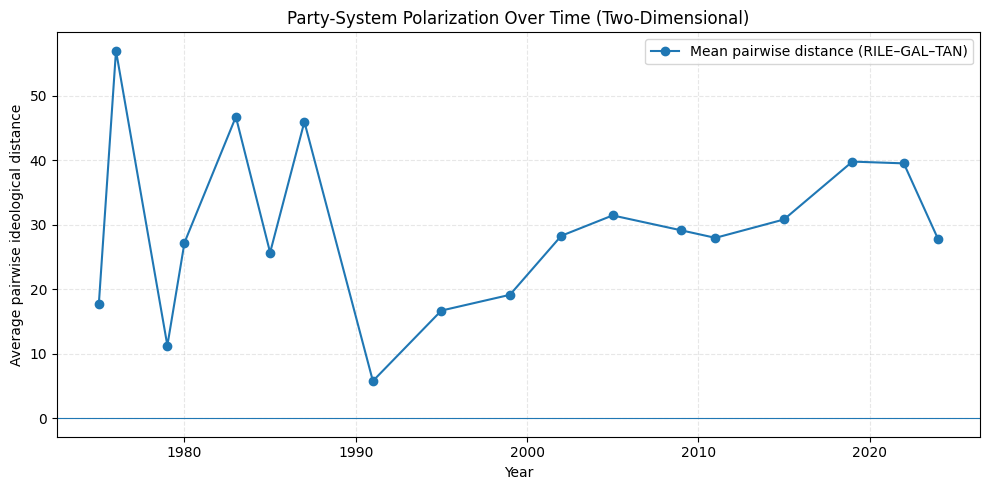

    year    PI_rile  PI_galtan     MPD_2D  Spread_rile  Spread_galtan  \
0   1975   6.761000   5.776000  17.784633       13.522         11.552   
1   1976  23.836500  15.582000  56.955332       47.673         31.164   
2   1979   1.338231   7.706677  11.284439        2.863         16.681   
3   1980  13.724507   9.673809  27.228490       33.533         21.750   
4   1983  17.691060  24.816521  46.712908       41.628         67.548   
5   1985   4.796445  17.120373  25.686195       13.153         44.315   
6   1987  28.899640  14.298450  45.936490       76.599         32.693   
7   1991   2.592384   2.117897   5.783266        6.347          4.539   
8   1995   9.470460   5.831248  16.695631       23.506         14.238   
9   1999  10.209912   8.549424  19.134619       28.154         23.298   
10  2002  14.192485  14.687442  28.277279       37.473         43.770   
11  2005  14.869270  17.690299  31.439637       38.244         52.349   
12  2009  15.124467  13.870934  29.131803       37.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# === Load calibrated positions ===
df = pd.read_csv("merged_official_modelled_calibrated.csv")

# Use the “best available” series: official when present, else calibrated modelled (e.g., 2024)
for c in ["rile_official", "rile_calibrated", "galtan_official", "galtan_calibrated"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["rile_best"]   = df["rile_official"].where(df["rile_official"].notna(), df["rile_calibrated"])
df["galtan_best"] = df["galtan_official"].where(df["galtan_official"].notna(), df["galtan_calibrated"])

df["year"]  = pd.to_numeric(df["year"], errors="coerce")
df["party"] = df["party"].astype(str).str.strip()

# === Helper functions (no seat weights) ===
def axis_std(x):
    """Unweighted standard deviation (Dalton PI equivalent without weights)."""
    x = np.asarray(x, dtype=float)
    return float(np.std(x))  # population std (ddof=0)

def mean_pairwise_distance_2d(X):
    """Average Euclidean distance over all unordered pairs in 2D."""
    if len(X) < 2:
        return np.nan
    dists = []
    for i, j in combinations(range(len(X)), 2):
        d = np.linalg.norm(X[i] - X[j])
        dists.append(d)
    return float(np.mean(dists))

# === Compute polarization per year ===
records = []
for year, g in df.dropna(subset=["year"]).groupby("year"):
    g = g.dropna(subset=["rile_best", "galtan_best"])
    if g.empty:
        continue

    # Axis-wise polarization (computed but not plotted)
    rile_pi   = axis_std(g["rile_best"].values)
    galtan_pi = axis_std(g["galtan_best"].values)

    # 2D polarization (mean pairwise distance in RILE–GALTAN plane)
    X = g[["rile_best", "galtan_best"]].to_numpy(dtype=float)
    d2 = mean_pairwise_distance_2d(X)

    # Spreads
    rile_spread   = g["rile_best"].max() - g["rile_best"].min()
    galtan_spread = g["galtan_best"].max() - g["galtan_best"].min()

    records.append({
        "year": int(year),
        "PI_rile": rile_pi,
        "PI_galtan": galtan_pi,
        "MPD_2D": d2,
        "Spread_rile": rile_spread,
        "Spread_galtan": galtan_spread,
        "n_parties": len(g)
    })

pol = pd.DataFrame(records).sort_values("year")

# === Plot: combined 2D polarization only ===
plt.figure(figsize=(10, 5))
plt.plot(pol["year"], pol["MPD_2D"], marker="o",
         label="Mean pairwise distance (RILE–GAL–TAN)")
plt.title("Party-System Polarization Over Time (Two-Dimensional)")
plt.xlabel("Year")
plt.ylabel("Average pairwise ideological distance")
plt.axhline(0, linewidth=0.8)
plt.legend()
plt.grid(axis="both", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# (Optional) Inspect table
print(pol.head(20))


**2011-2025**

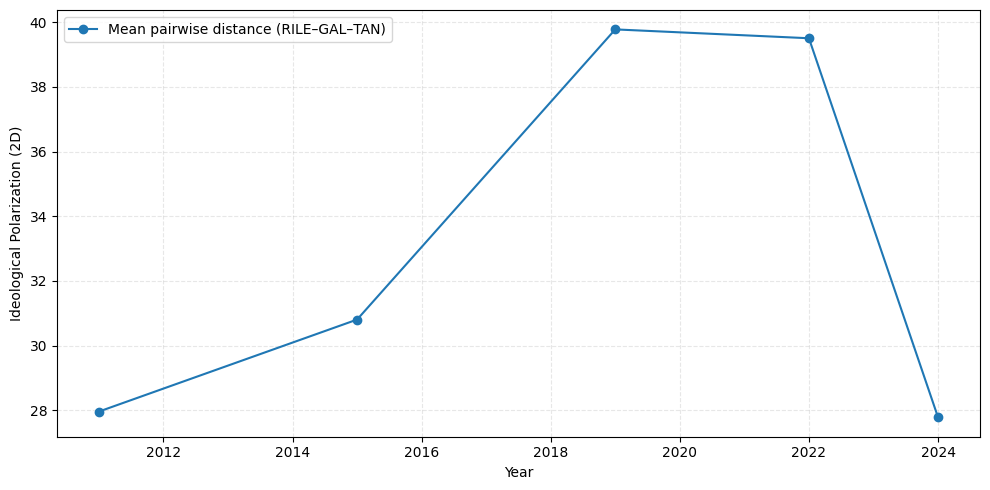

   year    PI_rile  PI_galtan     MPD_2D  Spread_rile  Spread_galtan  \
0  2011  19.375129   5.460367  27.961912       58.637         15.924   
1  2015   7.449562  20.533382  30.806129       22.177         61.623   
2  2019  25.177097  16.855516  39.776552       82.335         47.665   
3  2022  23.602007  20.370567  39.502887       83.535         73.521   
4  2024  17.394260  11.273350  27.784544       59.000         31.750   

   n_parties  
0          6  
1          5  
2         10  
3         10  
4         10  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# === Load calibrated positions ===
df = pd.read_csv("merged_official_modelled_calibrated.csv")

# Use the “best available” series: official when present, else calibrated modelled (e.g., 2024)
for c in ["rile_official", "rile_calibrated", "galtan_official", "galtan_calibrated"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["rile_best"]   = df["rile_official"].where(df["rile_official"].notna(), df["rile_calibrated"])
df["galtan_best"] = df["galtan_official"].where(df["galtan_official"].notna(), df["galtan_calibrated"])

df["year"]  = pd.to_numeric(df["year"], errors="coerce")
df["party"] = df["party"].astype(str).str.strip()

# === Restrict to 2011–2025 ===
df = df[(df["year"] >= 2011) & (df["year"] <= 2025)]

# === Helper functions (no seat weights) ===
def axis_std(x):
    """Unweighted standard deviation (Dalton PI equivalent without weights)."""
    x = np.asarray(x, dtype=float)
    return float(np.std(x))  # population std (ddof=0)

def mean_pairwise_distance_2d(X):
    """Average Euclidean distance over all unordered pairs in 2D."""
    if len(X) < 2:
        return np.nan
    dists = []
    for i, j in combinations(range(len(X)), 2):
        d = np.linalg.norm(X[i] - X[j])
        dists.append(d)
    return float(np.mean(dists))

# === Compute polarization per year ===
records = []
for year, g in df.dropna(subset=["year"]).groupby("year"):
    g = g.dropna(subset=["rile_best", "galtan_best"])
    if g.empty:
        continue

    # Axis-wise polarization (computed but not plotted)
    rile_pi   = axis_std(g["rile_best"].values)
    galtan_pi = axis_std(g["galtan_best"].values)

    # 2D polarization (mean pairwise distance in RILE–GALTAN plane)
    X = g[["rile_best", "galtan_best"]].to_numpy(dtype=float)
    d2 = mean_pairwise_distance_2d(X)

    # Spreads
    rile_spread   = g["rile_best"].max() - g["rile_best"].min()
    galtan_spread = g["galtan_best"].max() - g["galtan_best"].min()

    records.append({
        "year": int(year),
        "PI_rile": rile_pi,
        "PI_galtan": galtan_pi,
        "MPD_2D": d2,
        "Spread_rile": rile_spread,
        "Spread_galtan": galtan_spread,
        "n_parties": len(g)
    })

pol = pd.DataFrame(records).sort_values("year")

# === Plot: combined 2D polarization only ===
plt.figure(figsize=(10, 5))
plt.plot(
    pol["year"],
    pol["MPD_2D"],
    marker="o",
    label="Mean pairwise distance (RILE–GAL–TAN)"
)
plt.xlabel("Year")
plt.ylabel("Ideological Polarization (2D)")
plt.legend()
plt.grid(axis="both", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# (Optional) Inspect table
print(pol.head(20))


## Analysis

This section examines how the substantive priorities of political parties evolve over time by analysing changes in the distribution of Manifesto Project policy topics (perXXX codes) across electoral programs. Using the all_docs_summary dataset together with the official Manifesto Project topic mapping, we identify which issues gain or lose prominence between two selected election years for a given party.

The analysis proceeds by extracting each topic’s relative share within an electoral program, normalising these values to ensure comparability, and computing the change in topic emphasis across years. To provide interpretable results, topic codes are matched to their descriptive labels, categorised by ideological orientation (left, right, or neutral), and visualised using diverging bar plots that highlight the strongest increases and decreases in attention. This approach allows us to detect meaningful programmatic shifts, track the emergence or decline of issue areas, and better understand how parties adjust their rhetorical and policy agendas over time.

This code loads the Manifesto Project policy mapping file and constructs a dictionary that links each policy variable code (e.g., perXXX) to its corresponding descriptive label for use in interpreting and presenting results.

In [3]:
import pandas as pd

# Load mapping file
map_df = pd.read_csv("manifesto_policy_variables.csv")

# Build a dictionary: {perXXX → Description}
LABELS = dict(zip(map_df["Variable"].str.strip(), map_df["Description"].str.strip()))


This code merges official Manifesto Project Dataset (MPDS) data with modelled manifesto estimates for 2024 in order to construct a continuous time series that allows party issue emphases and topic-level shifts to be traced consistently over time, including the most recent election year.

In [4]:
import pandas as pd

# ========= MERGE MPDS + 2024 MODELLED =========
MP_PATH  = "MPDataset_MPDS2025a_PT_clean.csv"
#SUM_PATH = "_mp_pipeline/reports/all_docs_summary.csv"
SUM_PATH = "all_docs_summary.csv"

# --- load ---
df_mp  = pd.read_csv(MP_PATH, low_memory=False)
df_24  = pd.read_csv(SUM_PATH, low_memory=False)

# --- standardize party and year ---
# MPDS: partyabbrev -> party
if "partyabbrev" not in df_mp.columns:
    raise KeyError("Expected 'partyabbrev' in MPDataset_MPDS2025a_PT_clean.csv")

df_mp["party"] = df_mp["partyabbrev"].astype(str).str.strip()
df_mp["year"]  = pd.to_numeric(df_mp["year"], errors="coerce")

# all_docs_summary: already has 'party'
df_24["party"] = df_24["party"].astype(str).str.strip()
df_24["year"]  = pd.to_numeric(df_24["year"], errors="coerce")

# keep only 2024 rows from the modelled file
df_24 = df_24[df_24["year"] == 2024].copy()

# OPTIONAL: clean doc_id if present
for d in (df_mp, df_24):
    if "doc_id" in d.columns:
        d["doc_id"] = d["doc_id"].astype(str).str.strip()

# --- align columns & append 2024 modelled rows ---
common_cols = sorted(set(df_mp.columns) & set(df_24.columns))

df = pd.concat(
    [
        df_mp[common_cols],   # all MPDS years
        df_24[common_cols],   # plus 2024 modelled docs
    ],
    ignore_index=True
)

# quick sanity check
print("Merged shape:", df.shape)
print("Years per party (first few rows):")
print(df[["party", "year"]].dropna().drop_duplicates().sort_values(["party", "year"]).head(20))


Merged shape: (131, 58)
Years per party (first few rows):
     party  year
24    ASDI  1980
63      BE  1999
70      BE  2002
77      BE  2005
84      BE  2009
90      BE  2011
98      BE  2015
104     BE  2019
114     BE  2022
121     BE  2024
5      CDS  1975
10     CDS  1976
17     CDS  1979
26     CDS  1980
34     CDS  1983
43     CDS  1985
51     CDS  1987
56     CDS  1991
62   CDSPP  1995
68   CDSPP  1999


### RILE Change in Topics

This visualization shows the change in RILE related topics for a party between two specified years.

Topics coded in blue are RIGHT-coded topics, while topics coded in red are LEFT-coded topics. Neutral topics are grey.

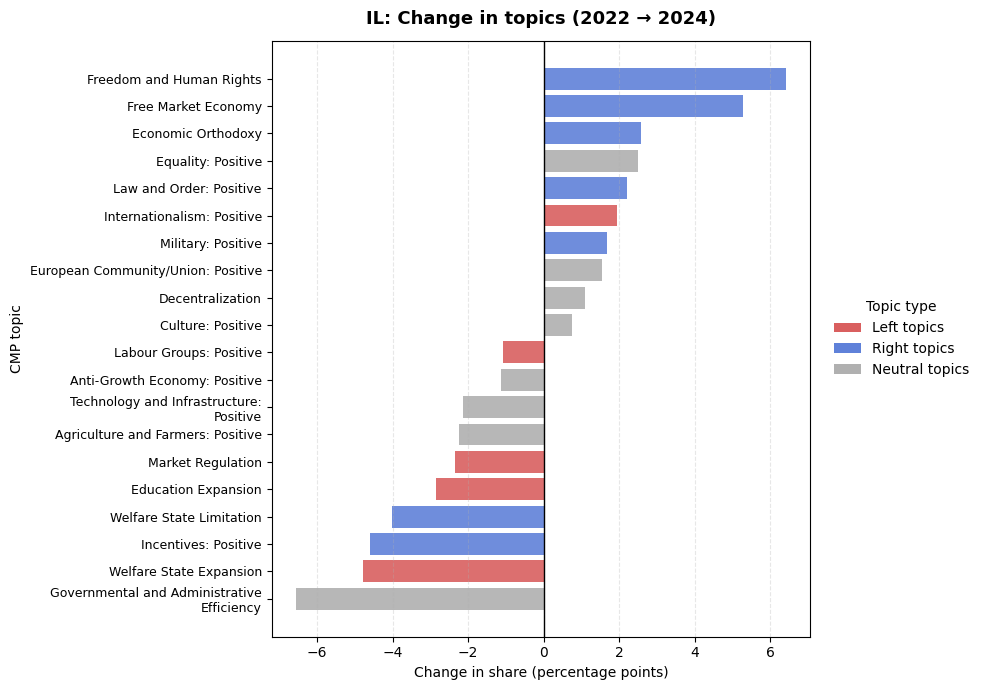

In [5]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Mapping: perXXX -> Description ---
MAP_PATH = "manifesto_policy_variables.csv"   # adjust if needed
map_df = pd.read_csv(MAP_PATH)
map_df.columns = [c.strip() for c in map_df.columns]  # tidy headers
LABELS = dict(zip(map_df["Variable"].astype(str).str.strip(),
                  map_df["Description"].astype(str).str.strip()))

# ----------------------------------------
# LEFT / RIGHT / NEUTRAL color mapping
# ----------------------------------------
RIGHT = {104, 201, 203, 305, 401, 402, 407, 414, 505, 601, 603, 605, 606}
LEFT  = {103, 105, 106, 107, 403, 404, 406, 412, 413, 504, 506, 701, 202}

def topic_side(code):
    """Return LEFT, RIGHT, or NEUTRAL based on perXXX code."""
    base = code.replace("per", "").split(".")[0]   # "per404" -> "404"
    try:
        num = int(base)
    except ValueError:
        # for things like 'perH' or any non-numeric, treat as neutral
        return "NEUTRAL"

    if num in LEFT:
        return "LEFT"
    elif num in RIGHT:
        return "RIGHT"
    return "NEUTRAL"


# ========= Find all CMP topic columns =========
def find_per_columns(cols):
    per_cols = [c for c in cols if re.fullmatch(r"per\d{3}(?:\.\d+)?", str(c))]
    # some exports include 'perH' or similar catch-all
    if "perH" in cols:
        per_cols.append("perH")
    # sort by numeric part so 305 < 305.1, etc.
    key = lambda s: tuple(
        int(x) if x.isdigit() else x
        for x in re.findall(r"\d+|[^\d]", s.replace("per", ""))
    )
    return sorted(per_cols, key=key)

PER_COLS = find_per_columns(df.columns)
if not PER_COLS:
    raise ValueError("No 'perXXX' columns found in merged df.")


# ========= Helpers =========
def pick_party_year_row(d, party, year):
    """
    Choose the best row for (party, year). If multiple rows (e.g., multiple docs),
    pick the one with the largest n_quasisentences; else fall back to the first.
    """
    sub = d[(d["party"] == party) & (d["year"] == year)]
    if sub.empty:
        raise ValueError(f"No row for party={party}, year={year}")
    if "n_quasisentences" in sub.columns and sub["n_quasisentences"].notna().any():
        return sub.loc[sub["n_quasisentences"].astype(float).idxmax()]
    return sub.iloc[0]

def per_series(row, normalize=True):
    """
    Extract the perXXX vector from a row as a Series (float).
    If normalize=True, re-scales to sum to 1.0 (i.e., 100%).
    """
    s = row[PER_COLS].apply(pd.to_numeric, errors="coerce").fillna(0.0).copy()
    if normalize:
        tot = s.sum()
        if tot > 0:
            s = s / tot
    return s

def topic_change_table(d, party, y0, y1, normalize=True, top_n=15, to_percent=True):
    """
    Compute topic share deltas between y1 and y0 for one party.
    Returns a tidy DataFrame: [code, delta, share_y0, share_y1]
    """
    r0 = pick_party_year_row(d, party, y0)
    r1 = pick_party_year_row(d, party, y1)

    s0 = per_series(r0, normalize=normalize)
    s1 = per_series(r1, normalize=normalize)

    # align to be safe
    s0, s1 = s0.align(s1, fill_value=0.0)

    delta = (s1 - s0).sort_values()
    out = pd.DataFrame({
        "code": delta.index,
        "delta": delta.values,
        "share_" + str(y0): s0[delta.index].values,
        "share_" + str(y1): s1[delta.index].values
    })

    # keep strongest moves (by signed delta, symmetric top/bottom)
    out = pd.concat([out.nsmallest(top_n, "delta"),
                     out.nlargest(top_n, "delta")]).sort_values("delta")

    if to_percent:
        out[["delta", "share_" + str(y0), "share_" + str(y1)]] *= 100.0

    return out.reset_index(drop=True)


# ========= Plotting =========
def plot_topic_change(d, party, y0, y1, normalize=True, top_n=15, to_percent=True,
                      title=None, save_path=None):

    tbl = topic_change_table(d, party, y0, y1, normalize, top_n, to_percent)

    # Map codes -> human labels
    tbl["label"] = tbl["code"].map(LABELS).fillna(tbl["code"])

    # Add ideological side + color mapping
    side_colors = {
        "LEFT":    "#d95f5f",  # red
        "RIGHT":   "#5f81d9",  # blue
        "NEUTRAL": "#b0b0b0"   # grey
    }

    tbl["side"] = tbl["code"].apply(topic_side)
    colors = tbl["side"].map(side_colors)

    y_pos = np.arange(len(tbl))

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.barh(y_pos, tbl["delta"], color=colors, alpha=0.9)

    ax.axvline(0, color="black", lw=1)
    ax.grid(axis="x", linestyle="--", alpha=0.3)
    ax.grid(axis="y", visible=False)

    import textwrap
    wrapped = ["\n".join(textwrap.wrap(lbl, 36)) for lbl in tbl["label"]]
    ax.set_yticks(y_pos)
    ax.set_yticklabels(wrapped, fontsize=9)
    ax.set_ylabel("CMP topic")

    if title is None:
        title = f"{party}: Change in topics ({y0} → {y1})"
    ax.set_title(title, pad=12, fontsize=13, weight="bold")
    ax.set_xlabel("Change in share" + (" (percentage points)" if to_percent else ""))

    # -------------------------
    # ⭐ ADD LEGEND (NEW PART)
    # -------------------------
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=side_colors["LEFT"], label="Left topics"),
        Patch(facecolor=side_colors["RIGHT"], label="Right topics"),
        Patch(facecolor=side_colors["NEUTRAL"], label="Neutral topics"),
    ]
    ax.legend(
        handles=legend_elements,
        title="Topic type",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )
    # -------------------------

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

    return tbl



def available_years(d, party):
    ys = (d.loc[d["party"] == party, "year"]
            .dropna().astype(int).sort_values().unique())
    return ys

def plot_latest_vs_prev(d, party, **kwargs):
    ys = available_years(d, party)
    if len(ys) < 2:
        raise ValueError(f"Not enough years for {party}. Have: {ys}")
    return plot_topic_change(d, party, ys[-2], ys[-1], **kwargs)


# ========= Example use =========
tbl_ps = plot_topic_change(df, "IL", 2022, 2024, top_n=10, normalize=True, to_percent=True)


### RILE Top Topics

This visualization indicates the top n RILE related topics in a given electoral program.

Topics coded in blue are RIGHT-coded topics, while topics coded in red are LEFT-coded topics. Neutral topics are grey.

In [6]:
def plot_top_topics(d, party, year,
                    top_n=20, normalize=True, to_percent=True,
                    title=None, save_path=None):

    # 1) get row & shares
    row = pick_party_year_row(d, party, year)
    s = per_series(row, normalize=normalize)

    if to_percent:
        s = s * 100

    # 2) pick top N topics
    s = s.sort_values(ascending=False).head(top_n)

    # 3) prepare labels + colors
    labels = s.index.map(lambda c: LABELS.get(c, c))
    sides = s.index.map(topic_side)   # assumes this returns LEFT / RIGHT / NEUTRAL or GAL / TAN / NEUTRAL

    # ---- RILE color mapping (LEFT / RIGHT / NEUTRAL) ----
    side_colors = {
        "LEFT":    "#d95f5f",   # red
        "RIGHT":   "#5f81d9",   # blue
        "NEUTRAL": "#b0b0b0"    # grey
    }
    colors = [side_colors.get(side, "#b0b0b0") for side in sides]

    # 4) plotting
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.barh(labels, s.values, color=colors)
    ax.invert_yaxis()

    if title is None:
        title = f"{party} — Top {top_n} topics in {year}"

    ax.set_title(title, fontsize=14, weight="bold")
    ax.set_xlabel("Share" + (" (%)" if to_percent else ""))

    # ---- Legend (same style as in code 1, but for LEFT / RIGHT / NEUTRAL) ----
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=side_colors["LEFT"],    label="Left topics"),
        Patch(facecolor=side_colors["RIGHT"],   label="Right topics"),
        Patch(facecolor=side_colors["NEUTRAL"], label="Neutral topics"),
    ]
    ax.legend(
        handles=legend_elements,
        title="Topic type",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.0,
        frameon=False,
    )

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=220, bbox_inches="tight")
    plt.show()

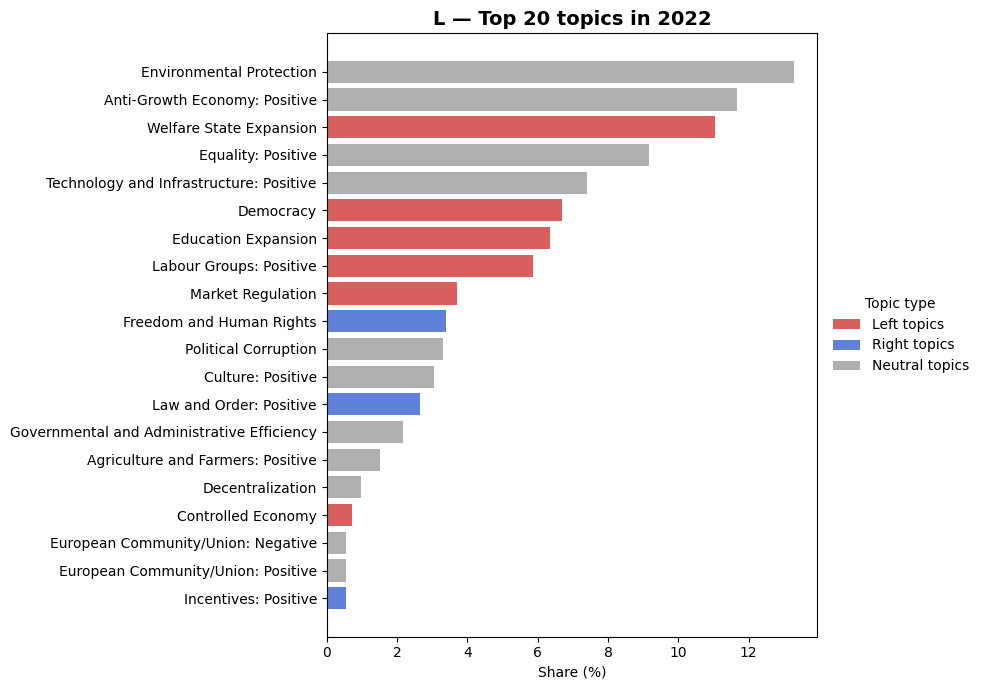

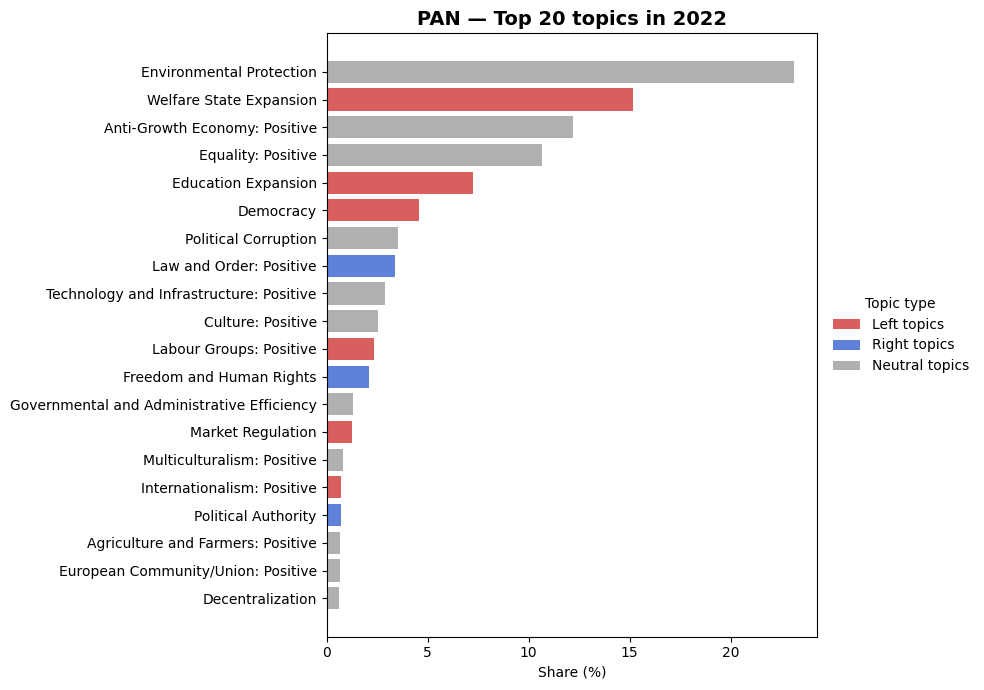

In [8]:
plot_top_topics(df, "L", 2022, top_n=20)
plot_top_topics(df, "PAN", 2022, top_n=20)


### GAL-TAN Change in Topics

This visualization shows the change in GAL-TAN topics for a party between two specified years.

Topics coded in orange are TAN-coded topics, while topics coded in green are GAL-coded topics. Neutral topics are grey.

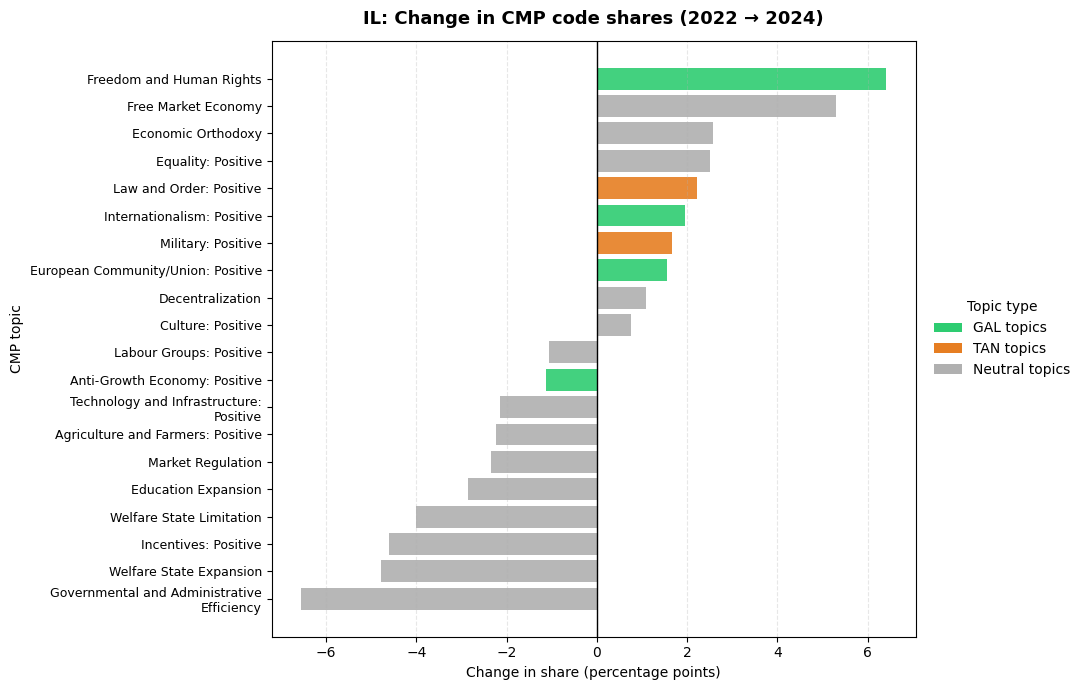

In [9]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Mapping: perXXX -> Description ---
MAP_PATH = "manifesto_policy_variables.csv"   # adjust if needed
map_df = pd.read_csv(MAP_PATH)
map_df.columns = [c.strip() for c in map_df.columns]  # tidy headers
LABELS = dict(zip(map_df["Variable"].astype(str).str.strip(),
                  map_df["Description"].astype(str).str.strip()))

# ----------------------------------------
# GAL / TAN / NEUTRAL color mapping
# ----------------------------------------
GAL_CODES = {105, 106, 107, 108, 201, 202, 416, 501, 602, 604, 607}
TAN_CODES = {104, 109, 110, 305, 410, 601, 603, 605, 608}

def topic_side(code):
    """Return GAL, TAN, or NEUTRAL based on perXXX code."""
    base = code.replace("per", "").split(".")[0]   # "per404" -> "404"
    try:
        num = int(base)
    except ValueError:
        return "NEUTRAL"

    if num in GAL_CODES:
        return "GAL"
    elif num in TAN_CODES:
        return "TAN"
    return "NEUTRAL"


# ========= 1) Use existing *merged* df =========
# (Assumes df already created by your merge cell:
#  df = pd.concat([df_mp[common_cols], df_24[common_cols]], ...))

# Basic cleaning (in case not already done)
for c in ["party", "doc_id"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

if "year" not in df.columns:
    raise KeyError("Expected a 'year' column in merged df")

df["year"] = pd.to_numeric(df["year"], errors="coerce")


# ========= 2) Find all CMP topic columns =========
def find_per_columns(cols):
    per_cols = [c for c in cols if re.fullmatch(r"per\d{3}(?:\.\d+)?", str(c))]
    if "perH" in cols:
        per_cols.append("perH")
    key = lambda s: tuple(
        int(x) if x.isdigit() else x
        for x in re.findall(r"\d+|[^\d]", s.replace("per",""))
    )
    return sorted(per_cols, key=key)

PER_COLS = find_per_columns(df.columns)
if not PER_COLS:
    raise ValueError("No 'perXXX' columns found in merged df")


# ========= 3) Helpers =========
def pick_party_year_row(d, party, year):
    sub = d[(d["party"] == party) & (d["year"] == year)]
    if sub.empty:
        raise ValueError(f"No row for party={party}, year={year}")
    if "n_quasisentences" in sub.columns and sub["n_quasisentences"].notna().any():
        return sub.loc[sub["n_quasisentences"].astype(float).idxmax()]
    return sub.iloc[0]

def per_series(row, normalize=True):
    s = row[PER_COLS].apply(pd.to_numeric, errors="coerce").fillna(0.0).copy()
    if normalize:
        tot = s.sum()
        if tot > 0:
            s = s / tot
    return s

def topic_change_table(d, party, y0, y1, normalize=True, top_n=15, to_percent=True):
    r0 = pick_party_year_row(d, party, y0)
    r1 = pick_party_year_row(d, party, y1)

    s0 = per_series(r0, normalize=normalize)
    s1 = per_series(r1, normalize=normalize)

    s0, s1 = s0.align(s1, fill_value=0.0)

    delta = (s1 - s0).sort_values()
    out = pd.DataFrame({
        "code": delta.index,
        "delta": delta.values,
        "share_" + str(y0): s0[delta.index].values,
        "share_" + str(y1): s1[delta.index].values
    })

    out = pd.concat(
        [out.nsmallest(top_n, "delta"),
         out.nlargest(top_n, "delta")]
    ).sort_values("delta")

    if to_percent:
        out[["delta", "share_" + str(y0), "share_" + str(y1)]] *= 100.0

    return out.reset_index(drop=True)


# ========= 4) Plotting (diverging bars) =========
def plot_topic_change(d, party, y0, y1, normalize=True, top_n=15, to_percent=True,
                      title=None, save_path=None):

    tbl = topic_change_table(d, party, y0, y1, normalize, top_n, to_percent)

    tbl["label"] = tbl["code"].map(LABELS).fillna(tbl["code"])

    side_colors = {
        "GAL":     "#2ECC71",   # green
        "TAN":     "#E67E22",   # orange
        "NEUTRAL": "#b0b0b0"    # grey
    }

    tbl["side"] = tbl["code"].apply(topic_side)
    colors = tbl["side"].map(side_colors)

    y_pos = np.arange(len(tbl))

    fig, ax = plt.subplots(figsize=(11, 7))
    ax.barh(y_pos, tbl["delta"], color=colors, alpha=0.9)

    ax.axvline(0, color="black", lw=1)
    ax.grid(axis="x", linestyle="--", alpha=0.3)
    ax.grid(axis="y", visible=False)

    import textwrap
    wrapped = ["\n".join(textwrap.wrap(lbl, 36)) for lbl in tbl["label"]]
    ax.set_yticks(y_pos)
    ax.set_yticklabels(wrapped, fontsize=9)
    ax.set_ylabel("CMP topic")

    if title is None:
        title = f"{party}: Change in CMP code shares ({y0} → {y1})"
    ax.set_title(title, pad=12, fontsize=13, weight="bold")
    ax.set_xlabel("Change in share" + (" (percentage points)" if to_percent else ""))

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=side_colors["GAL"],     label="GAL topics"),
        Patch(facecolor=side_colors["TAN"],     label="TAN topics"),
        Patch(facecolor=side_colors["NEUTRAL"], label="Neutral topics"),
    ]
    ax.legend(
        handles=legend_elements,
        title="Topic type",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.0,
        frameon=False,
    )

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

    return tbl


# ========= 5) Convenience runners =========
def available_years(d, party):
    ys = (d.loc[d["party"] == party, "year"]
            .dropna().astype(int).sort_values().unique())
    return ys

def plot_latest_vs_prev(d, party, **kwargs):
    ys = available_years(d, party)
    if len(ys) < 2:
        raise ValueError(f"Not enough years for {party}. Have: {ys}")
    return plot_topic_change(d, party, ys[-2], ys[-1], **kwargs)


# ========= 6) Example ========
tbl = plot_topic_change(df, "IL", 2022, 2024, top_n=10, normalize=True, to_percent=True)


### GAL-TAN Top Topics

This visualization shows the top n GAL-TAN topics for a given electoral program.

Topics coded in orange are TAN-coded topics, while topics coded in green are GAL-coded topics. Neutral topics are grey.

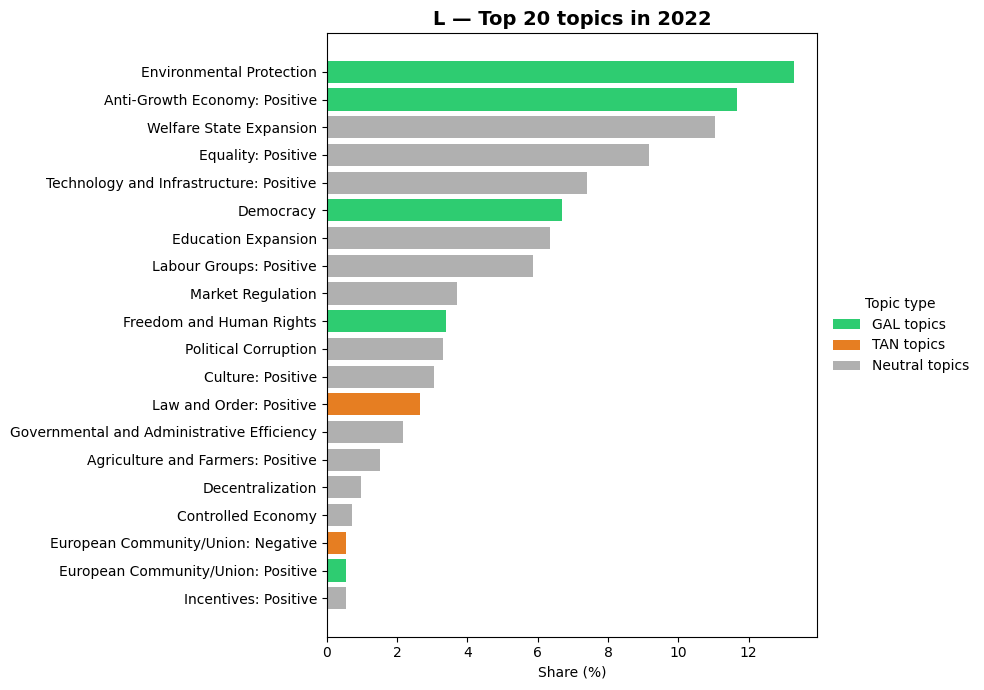

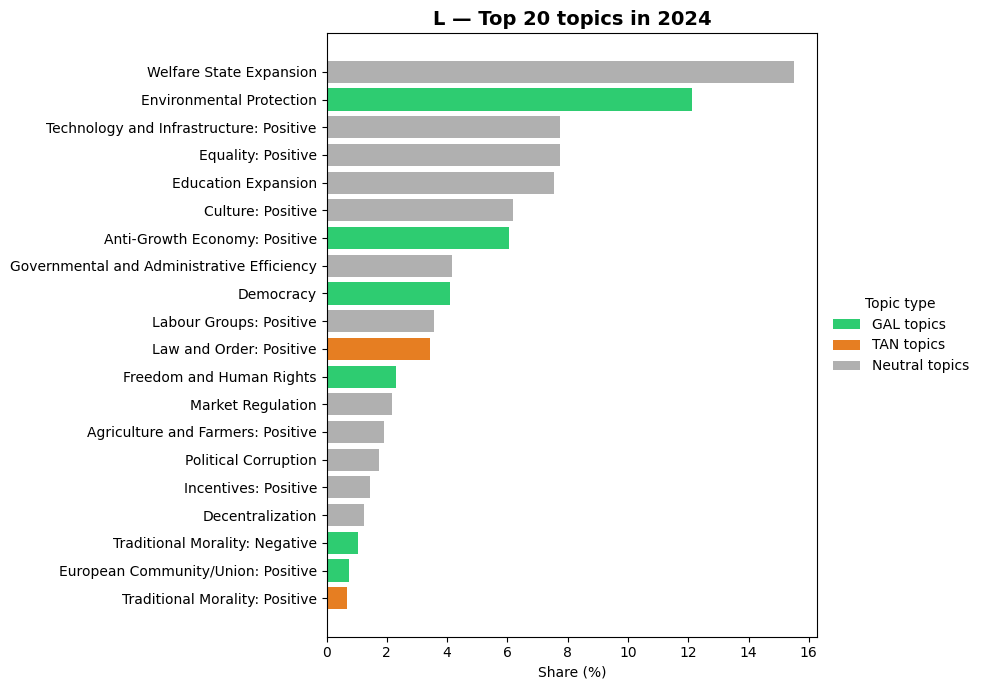

In [13]:
def plot_top_topics(d, party, year,
                    top_n=20, normalize=True, to_percent=True,
                    title=None, save_path=None):

    # 1) get row & shares
    row = pick_party_year_row(d, party, year)
    s = per_series(row, normalize=normalize)

    if to_percent:
        s = s * 100

    # 2) pick top N topics
    s = s.sort_values(ascending=False).head(top_n)

    # 3) prepare labels + colors
    labels = s.index.map(lambda c: LABELS.get(c, c))
    sides = s.index.map(topic_side)

    side_colors = {
        "GAL":     "#2ECC71",
        "TAN":     "#E67E22",
        "NEUTRAL": "#b0b0b0",
    }
    colors = [side_colors.get(s, "#b0b0b0") for s in sides]

    # 4) plotting
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.barh(labels, s.values, color=colors)
    ax.invert_yaxis()

    if title is None:
        title = f"{party} — Top {top_n} topics in {year}"

    ax.set_title(title, fontsize=14, weight="bold")
    ax.set_xlabel("Share" + (" (%)" if to_percent else ""))

    # -------- Legend on the side --------
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=side_colors["GAL"],     label="GAL topics"),
        Patch(facecolor=side_colors["TAN"],     label="TAN topics"),
        Patch(facecolor=side_colors["NEUTRAL"], label="Neutral topics"),
    ]
    ax.legend(
        handles=legend_elements,
        title="Topic type",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.0,
        frameon=False,
    )
    # ------------------------------------

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=220, bbox_inches="tight")
    plt.show()


plot_top_topics(df, "L", 2022, top_n=20)
plot_top_topics(df, "L", 2024, top_n=20)


## Missing Official Data

This final code audits the Manifesto Project dataset for the selected Portuguese parties by identifying, for each party, which election years lack manifesto data after the party’s first appearance, thereby documenting gaps in topic and ideological coverage over time.

In [ ]:
import pandas as pd

# === Load data ===
path = "MPDataset_MPDS2025a_PT_clean.csv"  # adjust if needed
df = pd.read_csv(path)

# --- Parties of interest ---
target_parties = {
    "PS", "PSD", "CDSPP", "BE", "PCP", "PEV",
    "IL", "CH", "PAN", "L"
}

# Clean & filter
df["partyabbrev"] = df["partyabbrev"].astype(str).str.strip()
df = df[df["partyabbrev"].isin(target_parties)].copy()

# Make sure year is numeric/int
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df = df.dropna(subset=["year"])
df["year"] = df["year"].astype(int)

# All election years where at least one of the target parties has data
all_years = sorted(df["year"].unique())

missing_rows = []

for party in sorted(target_parties):
    sub = df[df["partyabbrev"] == party]
    party_years = sorted(sub["year"].unique())

    # If the party has no programmes at all, skip it
    if not party_years:
        continue

    first_year = min(party_years)

    # Only consider election years from the first programme onwards
    relevant_years = [y for y in all_years if y >= first_year]

    # Missing election years for this party (from its first appearance)
    missing = sorted(set(relevant_years) - set(party_years))

    missing_rows.append({
        "partyabbrev": party,
        "first_year": first_year,
        "available_years": party_years,
        "missing_election_years": missing,
        "n_missing": len(missing)
    })

missing_df = pd.DataFrame(missing_rows).sort_values("partyabbrev")

print("All election years in dataset (target parties only):", all_years)
print("\nMissing election years per party (from first programme onward):")
print(missing_df.to_string(index=False))


All election years in dataset (target parties only): [np.int64(1975), np.int64(1976), np.int64(1979), np.int64(1980), np.int64(1983), np.int64(1985), np.int64(1987), np.int64(1991), np.int64(1995), np.int64(1999), np.int64(2002), np.int64(2005), np.int64(2009), np.int64(2011), np.int64(2015), np.int64(2019), np.int64(2022)]

Missing election years per party (from first programme onward):
partyabbrev  first_year                                                                                        available_years missing_election_years  n_missing
         BE        1999                                                       [1999, 2002, 2005, 2009, 2011, 2015, 2019, 2022]                     []          0
      CDSPP        1995                                                       [1995, 1999, 2002, 2005, 2009, 2011, 2019, 2022]                 [2015]          1
         CH        2019                                                                                           [2019, 2022]